In [1]:
# get all libraries

import os.path as osp
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np
import seaborn as sns
import time
import warnings
import contextlib

from sklearn import metrics
from sklearn.metrics import make_scorer,classification_report,confusion_matrix,ConfusionMatrixDisplay,roc_curve, auc,accuracy_score, f1_score, recall_score, precision_score, roc_auc_score, log_loss
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from category_encoders.leave_one_out import LeaveOneOutEncoder
from category_encoders import TargetEncoder

from hyperopt import hp, fmin, tpe,Trials
from IPython.display import HTML

In [2]:
# importing various regression algorithms
# Linear Models
from sklearn.linear_model import LinearRegression

# Decision Tree
from sklearn.tree import DecisionTreeRegressor

# Ensemble Models
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor

# Support Vector Machine
from sklearn.svm import SVR

# K-Nearest Neighbors
from sklearn.neighbors import KNeighborsRegressor

# XGBoost
from xgboost import XGBRegressor

# LightGBM
from lightgbm import LGBMRegressor

# CatBoost
from catboost import CatBoostRegressor


the dataset has these features:
* Unit Number - The unique identifier for a Engine type
*  Cycle - Elapsed Cycle
*  3 operational Settings
*  21  Sensor Settings

In [3]:
index_names = ['unit_number', 'time_cycles']
setting_names = ['setting_1', 'setting_2', 'setting_3']
sensor_names = ['sensor_{}'.format(i+1) for i in range(0,21)]
col_names = index_names + setting_names + sensor_names

In [4]:
# Read the training Dataset
# List of dataset file names
#data_files = ['train_FD001.txt', 'train_FD002.txt', 'train_FD003.txt', 'train_FD004.txt']

data_files = ['train_FD001.txt']
# Initialize an empty DataFrame to hold the combined data
combined_train_df = pd.DataFrame()

for file in data_files:
    data_path = osp.join(
        osp.curdir,'input',file)
    
    temp_df = pd.read_csv(data_path,sep='\s+',header=None,index_col=False,names=col_names)
    temp_df['source_file'] = file
    
    # Concatenate the temporary DataFrame into the combined DataFrame
    combined_train_df = pd.concat([combined_train_df, temp_df], ignore_index=True)
    
# Show the first 5 rows of the combined DataFrame
combined_train_df.head(5)

,unit_number,time_cycles,setting_1,setting_2,setting_3,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,...,sensor_13,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21,source_file
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,train_FD001.txt
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,train_FD001.txt
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,train_FD001.txt
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,train_FD001.txt
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,train_FD001.txt


In [5]:
#Check row/column count of data
combined_train_df.shape

(20631, 27)

In [6]:
combined_train_df.groupby('source_file').count()[['unit_number']].reset_index()

,source_file,unit_number
0,train_FD001.txt,20631


We decided to go against combining the input files as they are all different and will introduce noise

In [7]:
# Read the Validation Dataset
# List of dataset file names
#data_files = ['test_FD001.txt', 'test_FD002.txt', 'test_FD003.txt', 'test_FD004.txt']

data_files = ['test_FD001.txt']

# Initialize an empty DataFrame to hold the combined data
combined_test_df = pd.DataFrame()

for file in data_files:
    data_path = osp.join(
        osp.curdir,'input',file)
    
    temp_df = pd.read_csv(data_path,sep='\s+',header=None,index_col=False,names=col_names)
    temp_df['source_file'] = file
    
    # Concatenate the temporary DataFrame into the combined DataFrame
    combined_test_df = pd.concat([combined_test_df, temp_df], ignore_index=True)
    
# Show the first 5 rows of the combined DataFrame
combined_test_df.head(5)

,unit_number,time_cycles,setting_1,setting_2,setting_3,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,...,sensor_13,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21,source_file
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,...,2388.03,8125.55,8.4052,0.03,392,2388,100.0,38.86,23.3735,test_FD001.txt
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,...,2388.06,8139.62,8.3803,0.03,393,2388,100.0,39.02,23.3916,test_FD001.txt
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,...,2388.03,8130.10,8.4441,0.03,393,2388,100.0,39.08,23.4166,test_FD001.txt
3,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,...,2388.05,8132.90,8.3917,0.03,391,2388,100.0,39.00,23.3737,test_FD001.txt
4,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,...,2388.03,8129.54,8.4031,0.03,390,2388,100.0,38.99,23.4130,test_FD001.txt


In [8]:
combined_test_df.shape

(13096, 27)

In [9]:
combined_test_df.groupby('source_file').count()[['unit_number']].reset_index()

,source_file,unit_number
0,test_FD001.txt,13096


In [10]:
# Read the prediction values
# List of dataset file names
#data_files = ['RUL_FD001.txt', 'RUL_FD002.txt', 'RUL_FD003.txt', 'RUL_FD004.txt']

data_files = ['RUL_FD001.txt']

# Initialize an empty DataFrame to hold the combined data
y_final = pd.DataFrame()

for file in data_files:
    data_path = osp.join(
  osp.curdir,'input',file)
    
    y_temp = pd.read_csv(data_path,sep='\s+',header=None,index_col=False,names=['RUL'])
    y_temp['source_file'] = file
    
    y_final = pd.concat([y_final, y_temp], ignore_index=True)


y_final.head(5)

,RUL,source_file
0,112,RUL_FD001.txt
1,98,RUL_FD001.txt
2,69,RUL_FD001.txt
3,82,RUL_FD001.txt
4,91,RUL_FD001.txt


In [11]:
y_final.shape

(100, 2)

In [12]:
y_final.groupby('source_file').count()[['RUL']].reset_index()

,source_file,RUL
0,RUL_FD001.txt,100


Calculating the Remaining Useful Life (RUL) is a key aspect when working with the NASA Turbo Fan Jet Engine dataset. The dataset usually consists of multiple engines, each identified by a unit number, and for each engine, we have multiple cycles. The last cycle for each engine usually signifies failure. The idea is to calculate the RUL for each cycle as a countdown to this last cycle.

In [13]:
# create a function to calculate RUL

def calculate_RUL(df):
    # Sort the DataFrame by 'unit_number' and 'time_in_cycles'
    df = df.sort_values(['unit_number', 'time_cycles'])
    
    # Calculate max cycle for each unit
    max_cycle_df  = df.groupby('unit_number')['time_cycles'].max().reset_index()
    max_cycle_df.columns = ['unit_number', 'max_cycle']
    
    # Merge the max cycle back into the original dataframe
    df = df.merge(max_cycle_df, on='unit_number', how='left')
    
    # Calculate RUL for each row
    df['RUL'] = df['max_cycle'] - df['time_cycles']
    
    # Drop the max_cycle column
    df = df.drop('max_cycle', axis=1)
    return df

In [14]:
#Apply the function on the Train set
train_df= calculate_RUL(combined_train_df)
train_df.head(10)

,unit_number,time_cycles,setting_1,setting_2,setting_3,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,...,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21,source_file,RUL
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,train_FD001.txt,191
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,train_FD001.txt,190
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,train_FD001.txt,189
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,train_FD001.txt,188
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,train_FD001.txt,187
5,1,6,-0.0043,-0.0001,100.0,518.67,642.10,1584.47,1398.37,14.62,...,8132.85,8.4108,0.03,391,2388,100.0,38.98,23.3669,train_FD001.txt,186
6,1,7,0.0010,0.0001,100.0,518.67,642.48,1592.32,1397.77,14.62,...,8132.32,8.3974,0.03,392,2388,100.0,39.10,23.3774,train_FD001.txt,185
7,1,8,-0.0034,0.0003,100.0,518.67,642.56,1582.96,1400.97,14.62,...,8131.07,8.4076,0.03,391,2388,100.0,38.97,23.3106,train_FD001.txt,184
8,1,9,0.0008,0.0001,100.0,518.67,642.12,1590.98,1394.80,14.62,...,8125.69,8.3728,0.03,392,2388,100.0,39.05,23.4066,train_FD001.txt,183
9,1,10,-0.0033,0.0001,100.0,518.67,641.71,1591.24,1400.46,14.62,...,8129.38,8.4286,0.03,393,2388,100.0,38.95,23.4694,train_FD001.txt,182


In [15]:
#examine the datatype of the train set
train_df.dtypes

unit_number      int64
time_cycles      int64
setting_1      float64
setting_2      float64
setting_3      float64
sensor_1       float64
sensor_2       float64
sensor_3       float64
sensor_4       float64
sensor_5       float64
sensor_6       float64
sensor_7       float64
sensor_8       float64
sensor_9       float64
sensor_10      float64
sensor_11      float64
sensor_12      float64
sensor_13      float64
sensor_14      float64
sensor_15      float64
sensor_16      float64
sensor_17        int64
sensor_18        int64
sensor_19      float64
sensor_20      float64
sensor_21      float64
source_file     object
RUL              int64
dtype: object

In [16]:
#Check for any missing values
print(train_df.isnull().sum())

unit_number    0
time_cycles    0
setting_1      0
setting_2      0
setting_3      0
sensor_1       0
sensor_2       0
sensor_3       0
sensor_4       0
sensor_5       0
sensor_6       0
sensor_7       0
sensor_8       0
sensor_9       0
sensor_10      0
sensor_11      0
sensor_12      0
sensor_13      0
sensor_14      0
sensor_15      0
sensor_16      0
sensor_17      0
sensor_18      0
sensor_19      0
sensor_20      0
sensor_21      0
source_file    0
RUL            0
dtype: int64


In [17]:
#Get a high level summary of the data
train_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
unit_number,20631.0,51.506568,2.922763e+01,1.0000,26.0000,52.0000,77.0000,100.0000
time_cycles,20631.0,108.807862,6.888099e+01,1.0000,52.0000,104.0000,156.0000,362.0000
setting_1,20631.0,-0.000009,2.187313e-03,-0.0087,-0.0015,0.0000,0.0015,0.0087
setting_2,20631.0,0.000002,2.930621e-04,-0.0006,-0.0002,0.0000,0.0003,0.0006
setting_3,20631.0,100.000000,0.000000e+00,100.0000,100.0000,100.0000,100.0000,100.0000
sensor_1,20631.0,518.670000,6.537152e-11,518.6700,518.6700,518.6700,518.6700,518.6700
sensor_2,20631.0,642.680934,5.000533e-01,641.2100,642.3250,642.6400,643.0000,644.5300
sensor_3,20631.0,1590.523119,6.131150e+00,1571.0400,1586.2600,1590.1000,1594.3800,1616.9100
sensor_4,20631.0,1408.933782,9.000605e+00,1382.2500,1402.3600,1408.0400,1414.5550,1441.4900
sensor_5,20631.0,14.620000,3.394700e-12,14.6200,14.6200,14.6200,14.6200,14.6200


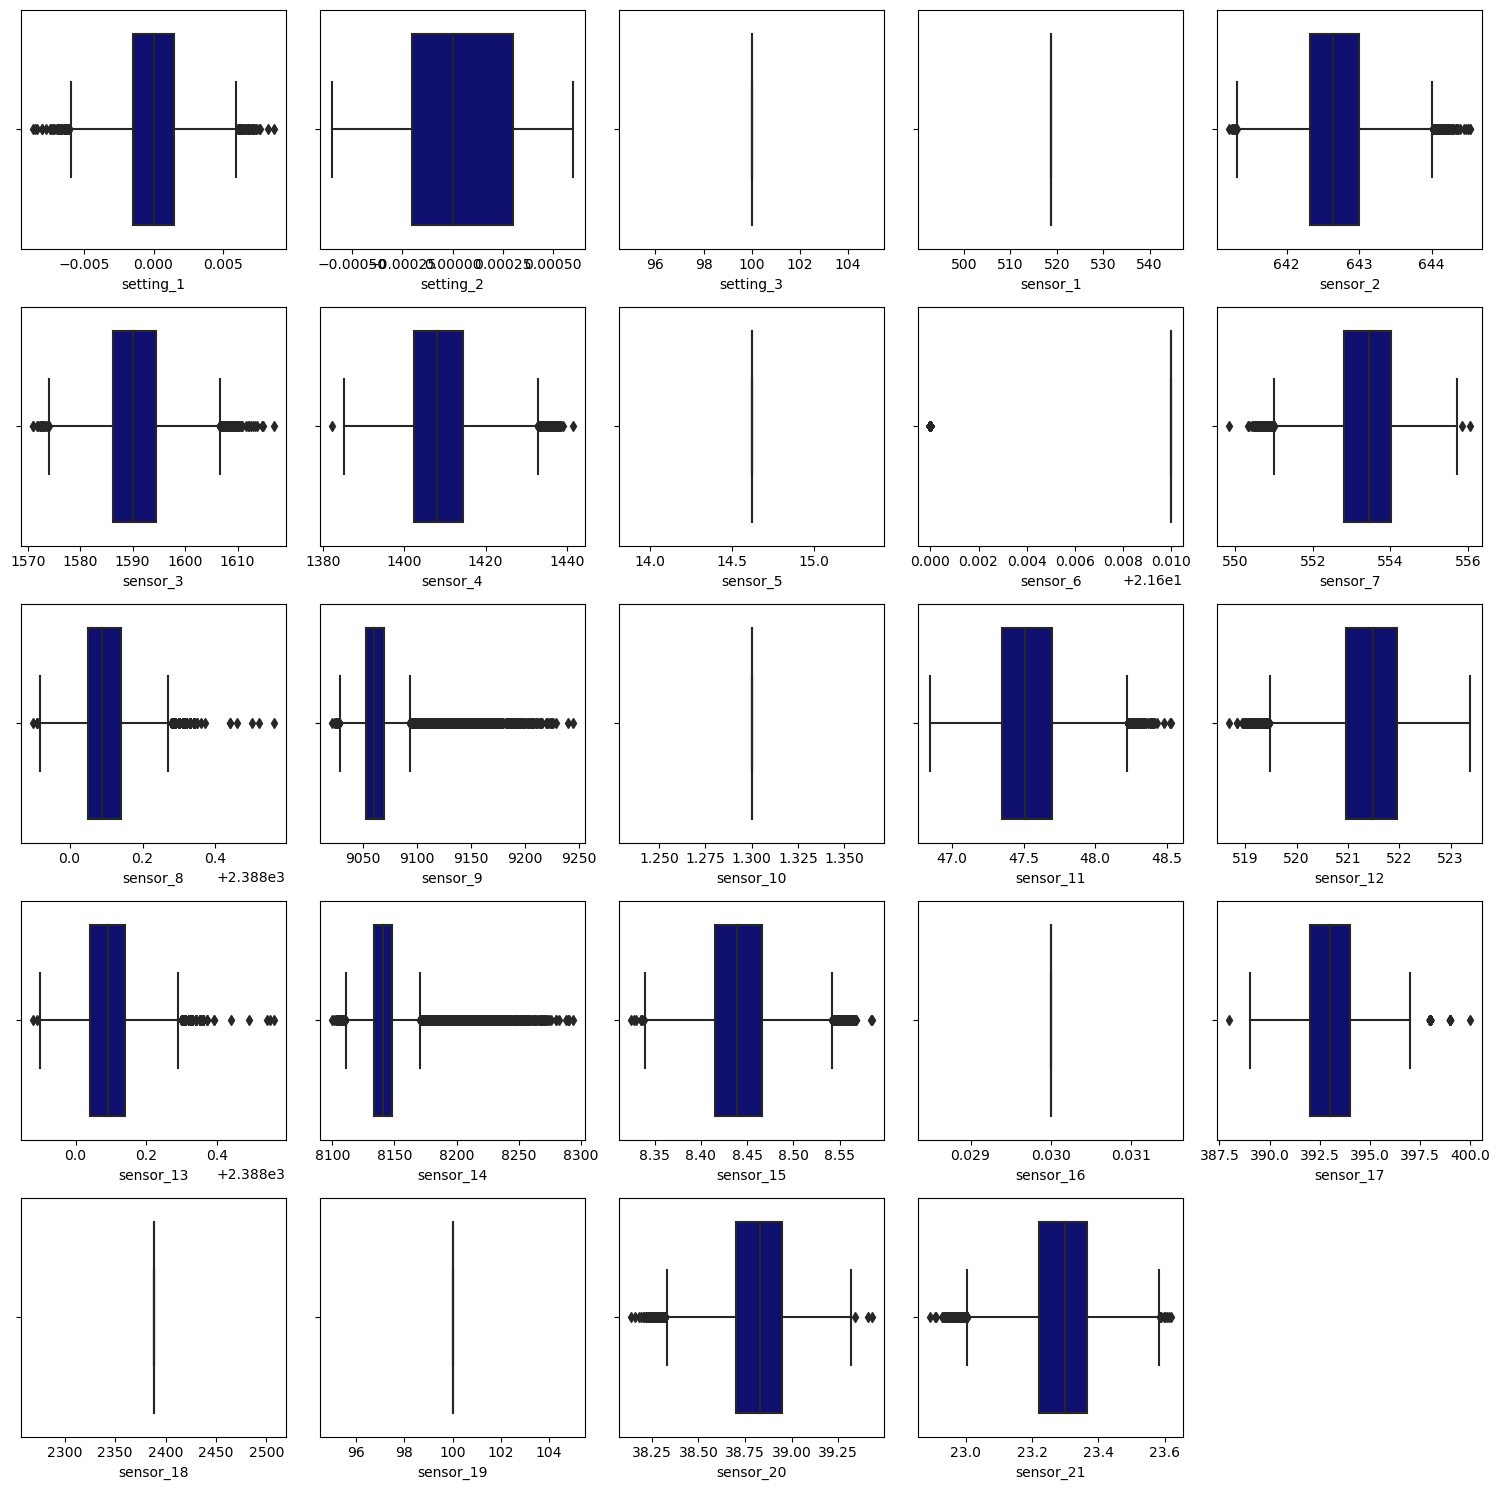

In [18]:
 # EDA for settings and sensors
numeric_cols = setting_names + sensor_names
num_plots = len(numeric_cols)
total_cols = 5
total_rows = num_plots // total_cols
total_rows += 1 if num_plots % total_cols > 0 else 0  # Add an extra row if there are remaining plots

fig, axs = plt.subplots(nrows=total_rows, ncols=total_cols, 
                        figsize=(3 * total_cols, 3 * total_rows))

# Flatten the axs array to make it easier to index
axs = axs.flatten()

for i, var in enumerate(numeric_cols):
    sns.boxplot(x=var,data=train_df, ax=axs[i],color="navy")

# Remove unused subplots
for i in range(num_plots, total_cols * total_rows):
    fig.delaxes(axs[i])

fig.tight_layout()


There are several constants here and we will drop those, but for now we will continue examining the data. 

<Axes: >

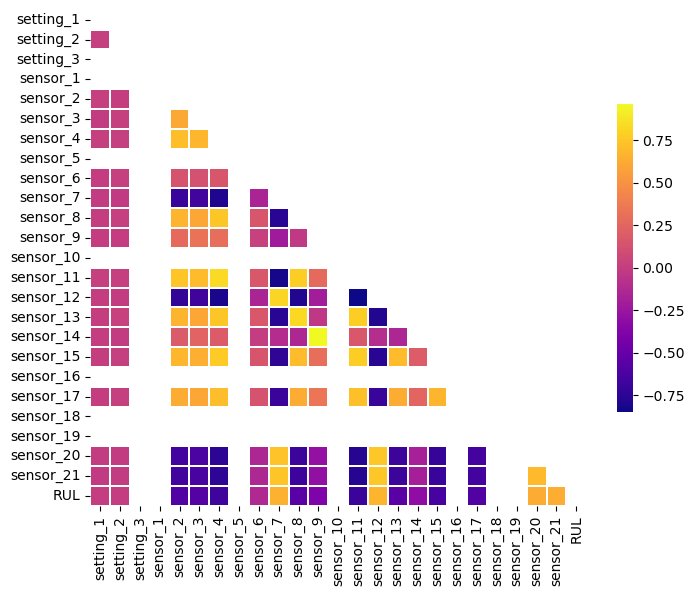

In [19]:
#examine correlations in the train DF
corr_cols = setting_names + sensor_names + ['RUL']
corr = train_df[corr_cols].corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(8, 8))
cmap = sns.diverging_palette(230, 10, as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap='plasma', square=True, linewidths=.01, cbar_kws={"shrink": .5})

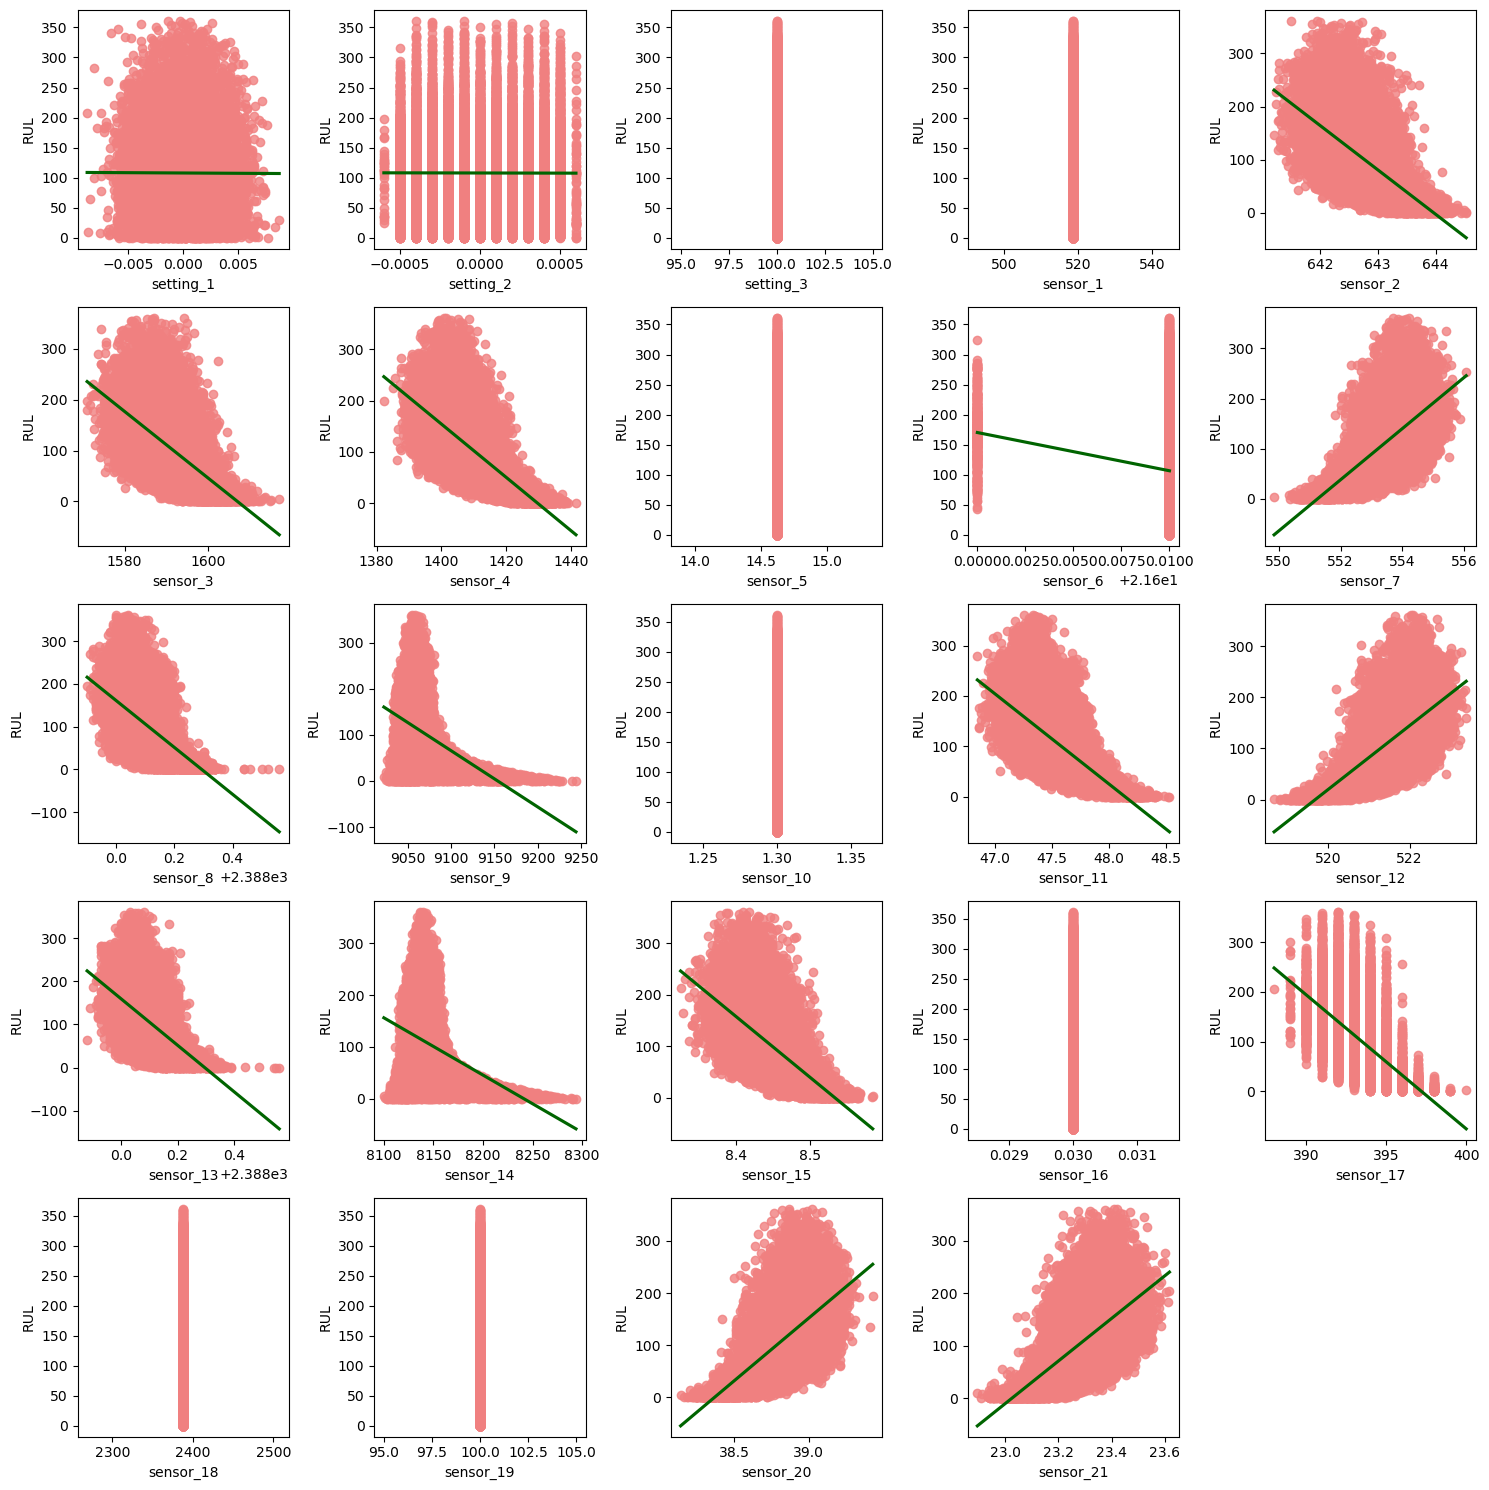

In [20]:
# Do some more EDA w.r.t. to the target

numeric_cols = setting_names + sensor_names
num_plots = len(numeric_cols)
total_cols = 5
total_rows = num_plots // total_cols
total_rows += 1 if num_plots % total_cols > 0 else 0  # Add an extra row if there are remaining plots

fig, axs = plt.subplots(nrows=total_rows, ncols=total_cols, figsize=(3 * total_cols, 3 * total_rows))

# Flatten the axs array to make it easier to index
axs = axs.flatten()

for i, var in enumerate(numeric_cols):
    sns.regplot(x=var, y="RUL", data=train_df, ax=axs[i], ci=False, 
                line_kws={'color': 'darkgreen'},scatter_kws={'color': 'lightcoral'})

# Remove unused subplots
for i in range(num_plots, total_cols * total_rows):
    fig.delaxes(axs[i])

fig.tight_layout()


From the above plots, it appears as these sensor values may be constant values or without any correlation with RUL
* setting_1
* setting_2
* setting_3
* sensor_1
* sensor_5
* sensor_6
* sensor_10
* sensor_16
* sensor_18
* sensor_19

We can generate some histograms to confirm if our suspicions are true

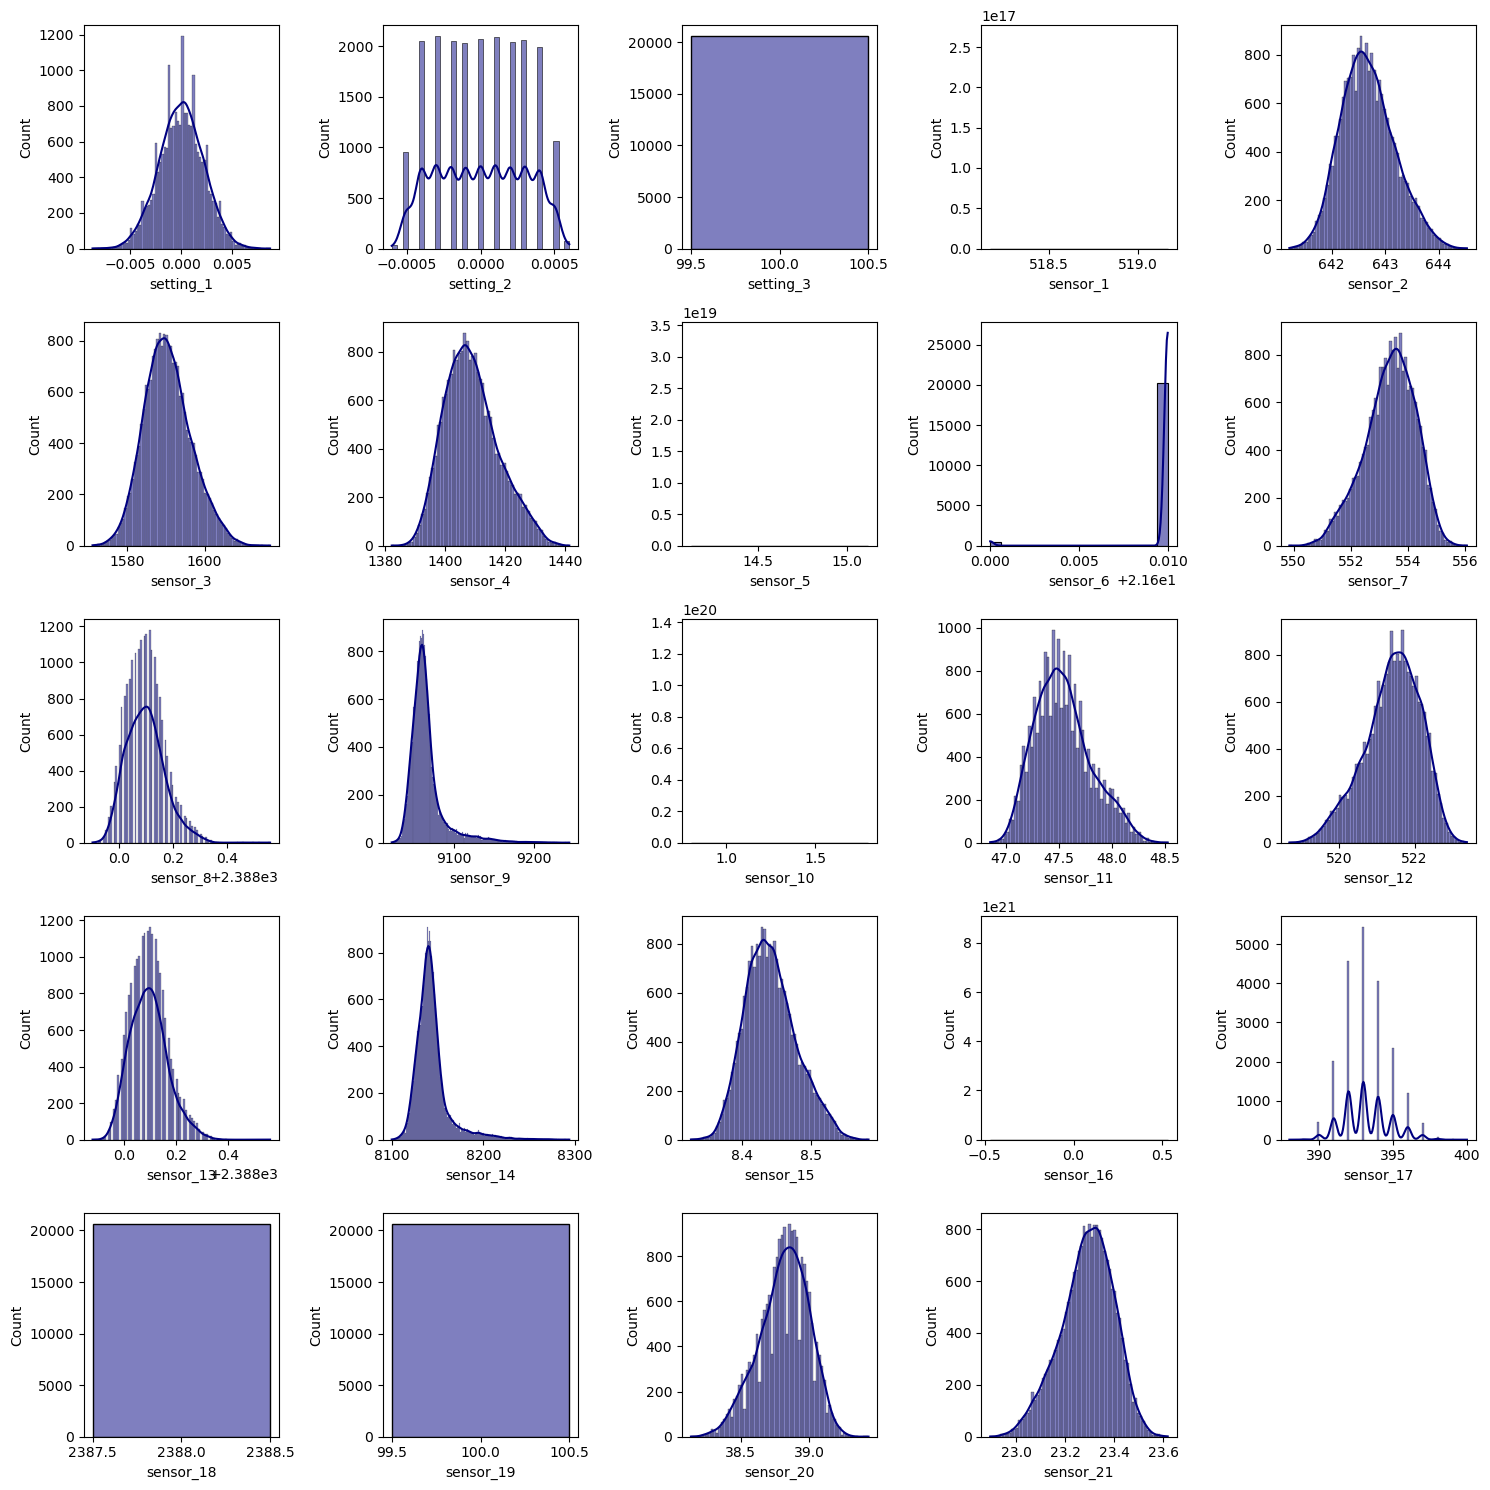

In [21]:
numeric_cols = setting_names + sensor_names

num_plots = len(numeric_cols)
total_cols = 5
total_rows = num_plots // total_cols
total_rows += 1 if num_plots % total_cols > 0 else 0  # Add an extra row if there are remaining plots

fig, axs = plt.subplots(nrows=total_rows, ncols=total_cols, figsize=(3* total_cols, 3 * total_rows))

# Flatten the axs array if total_rows > 1
axs = axs.flatten() if total_rows > 1 else axs

for i, var in enumerate(numeric_cols):
    sns.histplot(data=train_df, x=var, kde=True, color="navy", ax=axs[i])

# Remove unused subplots
for i in range(num_plots, total_cols * total_rows):
    fig.delaxes(axs[i])

fig.tight_layout()


Our suspicions are confirmed and we will drop these features for our model building. Lets proceed now to split our data into train-test sets and comparing various regression models on our data

Additionally, we can drop Sensor #17 that has very few values with low std deviation. 

In [22]:
drop_list = ["setting_1","setting_2","setting_3","sensor_1","sensor_5","sensor_6",
             "sensor_10","sensor_16","sensor_18","sensor_19","sensor_17"] + index_names
train_df_mod = train_df.drop(columns=drop_list)
train_df_mod.dtypes

sensor_2       float64
sensor_3       float64
sensor_4       float64
sensor_7       float64
sensor_8       float64
sensor_9       float64
sensor_11      float64
sensor_12      float64
sensor_13      float64
sensor_14      float64
sensor_15      float64
sensor_20      float64
sensor_21      float64
source_file     object
RUL              int64
dtype: object

In [23]:
#split training data into train and set split
X  = train_df_mod.drop(columns=["RUL","source_file"])
Y = train_df_mod["RUL"]
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2,random_state=42)

In [24]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(16504, 13)
(16504,)
(4127, 13)
(4127,)


### Create a function to evaluate various algorithms with Default Params

In [27]:
from sklearn.svm import LinearSVR

# Helper function
def quick_evaluate(X_train, X_test, y_train, y_test, name):
    
       
    lr = LinearRegression()
    dtr = DecisionTreeRegressor(random_state=42)
    rfr = RandomForestRegressor(random_state=42)
    gbr = GradientBoostingRegressor(random_state=42)
    abr = AdaBoostRegressor(random_state=42)
    svr = LinearSVR(fit_intercept=False)
    knr = KNeighborsRegressor()
    xgr = XGBRegressor(random_state=42)
    lgbmr = LGBMRegressor(random_state=42)
    catr = CatBoostRegressor(random_state=42,verbose=0)
  

      
    regressors = [('LR', lr),('DT', dtr),
                   ('RF', rfr),('GB', gbr),('AB', abr),
                   ('SV', svr),('KN', knr),('XB', xgr),
                  ('LB', lgbmr),('CB', catr)
                 ]
   
    n = len(y_test)
    p = X_test.shape[1]
        
    reg_lst = list()
    for reg_name, reg in regressors:
        print(reg_name,flush=True)
        %time reg.fit(X_train, y_train)
        y_pred = reg.predict(X_test)
        
        R2             = metrics.r2_score(y_test, y_pred)
        ADJ_R2         = 1 - (1-R2)*(n-1)/(n-p-1)
        MAPE           = metrics.mean_absolute_percentage_error(y_test,y_pred)
        MAE            = metrics.mean_absolute_error(y_test,y_pred)
        MSE            = metrics.mean_squared_error(y_test,y_pred)
        RMSE           = np.sqrt(metrics.mean_squared_error(y_test, y_pred))       
        params         = reg.get_params()
        
        df = pd.DataFrame({
                           "Method"    : [name],
                           "Regressor" : [reg_name],
                           "R2"        : [R2],
                           "Adj_R2"    : [ADJ_R2],
                           #"MAPE"      : [MAPE],
                           "MAE"       : [MAE],
                           "MSE"       : [MSE],                           
                           "RMSE"      : [RMSE],                            
                           "Model"     : [params]
                          })
        reg_lst.append(df)
    print(reg_lst)
    dfr = pd.concat([m for m in reg_lst], axis = 0).reset_index()
    dfr = dfr.drop(columns = "index",axis =1)
    return(dfr)

Pass#1 evaluate without scaling

In [28]:
with contextlib.redirect_stdout(None):
    evals = list()
    evals.append(quick_evaluate(X_train, X_test, y_train, y_test,'unscaled'))

LR
CPU times: total: 15.6 ms
Wall time: 14.7 ms
DT
CPU times: total: 1.2 s
Wall time: 263 ms
RF
CPU times: total: 9.78 s
Wall time: 18.3 s
GB
CPU times: total: 2.16 s
Wall time: 4.54 s
AB
CPU times: total: 359 ms
Wall time: 922 ms
SV
CPU times: total: 578 ms
Wall time: 901 ms
KN
CPU times: total: 15.6 ms
Wall time: 28.1 ms
XB


C:\Users\vsidd\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


CPU times: total: 1.44 s
Wall time: 212 ms
LB
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000500 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2655
[LightGBM] [Info] Number of data points in the train set: 16504, number of used features: 13
[LightGBM] [Info] Start training from score 107.559683
CPU times: total: 1.53 s
Wall time: 201 ms
CB
CPU times: total: 3.91 s
Wall time: 3.45 s
[     Method Regressor        R2   Adj_R2        MAE        MSE       RMSE  \
0  unscaled        LR  0.569291  0.56793  34.048139  1967.8206  44.360124   

                                               Model  
0  {'copy_X': True, 'fit_intercept': True, 'n_job...  ,      Method Regressor        R2    Adj_R2        MAE          MSE       RMSE  \
0  unscaled        DT  0.225441  0.222993  42.304337  3538.800097  59.487815   

                                               Model  
0  {'ccp_alpha': 0.0, 'criterion': 'sq

Pass#2 evaluate with scaled features

In [29]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
sscaler = StandardScaler()
mscaler = MinMaxScaler()

X_train_s = sscaler.fit_transform(X_train)
X_test_s =  sscaler.transform(X_test)

X_train_m = mscaler.fit_transform(X_train)
X_test_m =  mscaler.transform(X_test)

Pass#3 evaluate with log transform for skewed columns. 

From the histogram we saw earlier, we can see that both Sensor 9 and 14 are right skewed. We will apply log transformation on those 2 columns and see how it impacts. 

We will test for both unscaled + log transform and scaled + transform and evaluate all possible options. 



In [30]:
columns_to_transform=["sensor_9","sensor_14"]
X_train_l=X_train.copy()
X_test_l=X_test.copy()
X_train_l[columns_to_transform]=np.log1p(X_train_l[columns_to_transform])
X_test_l[columns_to_transform]=np.log1p(X_test_l[columns_to_transform])

sscaler = StandardScaler()
mscaler = MinMaxScaler()

X_train_sl = sscaler.fit_transform(X_train_l)
X_test_sl =  sscaler.transform(X_test_l)

X_train_ml = mscaler.fit_transform(X_train_l)
X_test_ml =  mscaler.transform(X_test_l)

In [31]:
with contextlib.redirect_stdout(None):
    #Standard scaling evaluation
    evals.append(quick_evaluate(X_train_s, X_test_s, y_train, y_test,'Standard'))
    
    #Minmax scaling evaluation
    evals.append(quick_evaluate(X_train_m, X_test_m, y_train, y_test,'MinMax'))
    
    #Log Transform with unscaled
    evals.append(quick_evaluate(X_train_l, X_test_l, y_train, y_test,'Unscaled & LogTransform'))
    
    #Log Transform evaluation with standard scaling
    evals.append(quick_evaluate(X_train_sl, X_test_sl, y_train, y_test,'LogTransform & Standard'))
    
    #Log Transform evaluation with Minmax scaling
    evals.append(quick_evaluate(X_train_ml, X_test_ml, y_train, y_test,'LogTransform & MinMax'))

C:\Users\vsidd\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [32]:
#evaluate results
pd.set_option('max_colwidth', 100)
evals_all = pd.concat([m for m in evals], axis = 0).reset_index()

evals_all = evals_all.drop(columns = "index",axis =1)
evals_all.sort_values(by=['R2','MAE'], ascending=False)

,Method,Regressor,R2,Adj_R2,MAE,MSE,RMSE,Model
38,Unscaled & LogTransform,LB,0.626217,0.625036,29.524030,1707.735991,41.324762,"{'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'spl..."
8,unscaled,LB,0.626216,0.625035,29.524481,1707.740395,41.324816,"{'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'spl..."
23,MinMax,GB,0.625082,0.623897,29.856970,1712.922995,41.387474,"{'alpha': 0.9, 'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.1..."
53,LogTransform & MinMax,GB,0.625080,0.623895,29.857007,1712.930624,41.387566,"{'alpha': 0.9, 'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.1..."
3,unscaled,GB,0.625071,0.623886,29.857775,1712.974487,41.388096,"{'alpha': 0.9, 'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.1..."
43,LogTransform & Standard,GB,0.625070,0.623885,29.859252,1712.980402,41.388167,"{'alpha': 0.9, 'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.1..."
13,Standard,GB,0.625069,0.623884,29.860150,1712.984205,41.388213,"{'alpha': 0.9, 'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.1..."
33,Unscaled & LogTransform,GB,0.625033,0.623848,29.859278,1713.148466,41.390198,"{'alpha': 0.9, 'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.1..."
18,Standard,LB,0.624993,0.623808,29.652871,1713.329287,41.392382,"{'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'spl..."
48,LogTransform & Standard,LB,0.624540,0.623354,29.617596,1715.398424,41.417369,"{'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'spl..."


We will use the unscaled data with log transform applied on 2 columns and go with LightGBM as that has performed the best in the quick evaluate function

In [50]:
import lightgbm as lgb


lgbm_params = {
    'n_estimators': [100],               # Keep the same (100 estimators)
    'num_leaves': [31],                 # Keep the same (31 leaves)
    'max_depth': [-1],                  # Keep the same (unlimited depth)
    'learning_rate': [0.03, 0.05, 0.1],  # Try different learning rates
    'subsample': [0.4, 0.5, 0.6],       # Adjust subsample values
    'colsample_bytree': [0.6, 0.7, 0.8], # Adjust feature subsampling
    'min_child_samples': [5, 10, 15],    # Try different min child samples
}


# Create GridSearchCV object
gridsearch_lgbm = GridSearchCV(
    lgb.LGBMRegressor(random_state=42),
    lgbm_params,
    cv=10,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    verbose=3
)

# Fit the grid search to the data (using X_train_l)
%time gridsearch_lgbm.fit(X_train_l, y_train)

Fitting 10 folds for each of 81 candidates, totalling 810 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000933 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2655
[LightGBM] [Info] Number of data points in the train set: 16504, number of used features: 13
[LightGBM] [Info] Start training from score 107.559683
CPU times: total: 3.09 s
Wall time: 1min


GridSearchCV(cv=10, estimator=LGBMRegressor(random_state=42), n_jobs=-1,
             param_grid={'colsample_bytree': [0.6, 0.7, 0.8],
                         'learning_rate': [0.03, 0.05, 0.1], 'max_depth': [-1],
                         'min_child_samples': [5, 10, 15],
                         'n_estimators': [100], 'num_leaves': [31],
                         'subsample': [0.4, 0.5, 0.6]},
             scoring='neg_root_mean_squared_error', verbose=3)

In [51]:
print('Initial score: ', gridsearch_lgbm.best_score_)
print('Initial parameters: ', gridsearch_lgbm.best_params_)
best_estimator = gridsearch_lgbm.best_estimator_

Initial score:  -41.31197133486329
Initial parameters:  {'colsample_bytree': 0.7, 'learning_rate': 0.05, 'max_depth': -1, 'min_child_samples': 10, 'n_estimators': 100, 'num_leaves': 31, 'subsample': 0.4}


In [83]:
'''
Initial parameters:  {'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': -1, 'min_child_samples': 20, 'n_estimators': 100, 'num_leaves': 31, 'subsample': 0.6, 'verbosity': 2}
Initial Score: R2 Score: 0.6244517256382611 RMSE: 41.422253982409444

Tuned Param 1: {'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': -1, 'min_child_samples': 15, 'n_estimators': 100, 'num_leaves': 31, 'subsample': 0.6, 'verbosity': 2}
Tuned Score 1: R2 Score: 0.6288763705798004 RMSE: 41.17751605847445

Tuned Param 2: {'colsample_bytree': 0.7, 'learning_rate': 0.05, 'max_depth': -1, 'min_child_samples': 10, 'n_estimators': 100, 'num_leaves': 31, 'subsample': 0.5}
Tuned Score 2: R2 Score: 0.6310180069190063 RMSE: 41.058532987438014

Tuned Param 2: {'colsample_bytree': 0.7, 'learning_rate': 0.05, 'max_depth': -1, 'min_child_samples': 10, 'n_estimators': 100, 'num_leaves': 31, 'subsample': 0.4}
Tuned Score 2: R2 Score: 0.6310180069190063 RMSE: 41.058532987438014
'''
best_lgbm_params = {
    'n_estimators': 100,
    'num_leaves': 31,
    'max_depth': -1,
    'learning_rate': 0.05,
    'subsample': 0.4,
    'colsample_bytree': 0.7,
    'min_child_samples': 10
}

# Create the LightGBM model using the best hyperparameters
best_lgbm_estimator = lgb.LGBMRegressor(**best_lgbm_params, random_state=42)

# Fit the model to the training data
best_lgbm_estimator.fit(X_train_l, y_train)

# Predict on the test data
y_pred_lgbm = best_lgbm_estimator.predict(X_test_l)

# Evaluation
r2 = metrics.r2_score(y_test, y_pred_lgbm)
rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred_lgbm))

print("R2 Score:", r2)
print("RMSE:", rmse)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000567 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2655
[LightGBM] [Info] Number of data points in the train set: 16504, number of used features: 13
[LightGBM] [Info] Start training from score 107.559683
R2 Score: 0.6310180069190063
RMSE: 41.058532987438014


Lets stop here as the R2/RMSE scores seem to be hitting a plateau. Can revisit later if needed. Let us proceed to Randomized search

In [73]:
import lightgbm as lgb
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

# Define the parameter grid for the randomized search
lgbm_params = {
    'n_estimators': [195, 200, 205],            # Experiment with different numbers of estimators
    'num_leaves': [26, 28, 30],                # Try different numbers of leaves
    'max_depth': [8, 9, 10],                   # Experiment with different max depths
    'learning_rate': [0.02, 0.025, 0.03],     # Try a range of learning rates
    'subsample': [0.42, 0.45, 0.48],          # Experiment with different subsample values
    'colsample_bytree': [0.43, 0.45, 0.47],   # Try different feature subsampling values
    'min_child_samples': [18, 20, 22]          # Experiment with different min child samples
}
# Create the RandomizedSearchCV object
randgridsearch_lgbm = RandomizedSearchCV(
    lgb.LGBMRegressor(random_state=42),
    param_distributions=lgbm_params,
    n_iter=50,  # Number of random combinations to try
    cv=10,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    verbose=3,
    random_state=42,  # Set random seed for reproducibility
    return_train_score=True
)

# Fit the randomized search to the data (using X_train and y_train)
%time randgridsearch_lgbm.fit(X_train_l, y_train)

Fitting 10 folds for each of 50 candidates, totalling 500 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000450 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2655
[LightGBM] [Info] Number of data points in the train set: 16504, number of used features: 13
[LightGBM] [Info] Start training from score 107.559683
CPU times: total: 1.97 s
Wall time: 1min 18s


RandomizedSearchCV(cv=10, estimator=LGBMRegressor(random_state=42), n_iter=50,
                   n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.43, 0.45, 0.47],
                                        'learning_rate': [0.02, 0.025, 0.03],
                                        'max_depth': [8, 9, 10],
                                        'min_child_samples': [18, 20, 22],
                                        'n_estimators': [195, 200, 205],
                                        'num_leaves': [26, 28, 30],
                                        'subsample': [0.42, 0.45, 0.48]},
                   random_state=42, return_train_score=True,
                   scoring='neg_root_mean_squared_error', verbose=3)

In [74]:
print('Initial score: ', randgridsearch_lgbm.best_score_)
print('Initial parameters: ', randgridsearch_lgbm.best_params_)
best_estimator_rs = randgridsearch_lgbm.best_estimator_

Initial score:  -41.23061684041151
Initial parameters:  {'subsample': 0.42, 'num_leaves': 28, 'n_estimators': 200, 'min_child_samples': 22, 'max_depth': 8, 'learning_rate': 0.03, 'colsample_bytree': 0.43}


In [84]:
'''
Initial parameters:  {'colsample_bytree': 0.6, 'learning_rate': 0.05, 'max_depth': 10, 'min_child_samples': 16, 'n_estimators': 153, 'num_leaves': 24, 'subsample': 0.4}
Initial Scores: R2 Score: 0.6289665556320825 RMSE: 41.172512574759594

Tuned parameters #1:  {'subsample': 0.4, 'num_leaves': 24, 'n_estimators': 153, 'min_child_samples': 20, 'max_depth': 10, 'learning_rate': 0.03, 'colsample_bytree': 0.5}
Tuned Scores #1: R2 Score: 0.6312727815308208 RMSE: 41.044355495928876

Tuned parameters #2:  {'subsample': 0.6, 'num_leaves': 20, 'n_estimators': 200, 'min_child_samples': 20, 'max_depth': 10, 'learning_rate': 0.05, 'colsample_bytree': 0.5}
Tuned Scores #2: R2 Score: 0.6290615581410152 RMSE: 41.167241159921

Tuned parameters #3:  {'subsample': 0.6, 'num_leaves': 20, 'n_estimators': 200, 'min_child_samples': 20, 'max_depth': 10, 'learning_rate': 0.05, 'colsample_bytree': 0.5}
Tuned Scores #3: R2 Score: 0.6290615581410152 RMSE: 41.167241159921

Tuned parameters #4:  {'subsample': 0.45, 'num_leaves': 28, 'n_estimators': 200, 'min_child_samples': 20, 'max_depth': 9, 'learning_rate': 0.025, 'colsample_bytree': 0.45}
Tuned Scores #4: R2 Score: 0.6320526946330393 RMSE: 41.0009250492852

Tuned parameters #5: {'subsample': 0.42, 'num_leaves': 28, 'n_estimators': 200, 'min_child_samples': 22, 'max_depth': 8, 'learning_rate': 0.03, 'colsample_bytree': 0.43}
Tuned Scores #5: R2 Score: 0.63089921334032 RMSE: 41.06514184321881
'''
best_lgbm_params = {
    'n_estimators': 200,
    'num_leaves': 28,
    'max_depth': 9,
    'learning_rate': 0.025,
    'subsample': 0.45,
    'colsample_bytree': 0.45,
    'min_child_samples': 20
}

# Create the LightGBM model using the best hyperparameters
best_lgbm_estimator_rs = lgb.LGBMRegressor(**best_lgbm_params, random_state=42)

# Fit the model to the training data
best_lgbm_estimator_rs.fit(X_train_l, y_train)

# Predict on the test data
y_pred_lgbm = best_lgbm_estimator_rs.predict(X_test_l)

# Evaluation
r2 = metrics.r2_score(y_test, y_pred_lgbm)
rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred_lgbm))

print("R2 Score:", r2)
print("RMSE:", rmse)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000675 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2655
[LightGBM] [Info] Number of data points in the train set: 16504, number of used features: 13
[LightGBM] [Info] Start training from score 107.559683
R2 Score: 0.6320526946330393
RMSE: 41.0009250492852


This is now tuned to a decent level. We will try Bayesian Hyperparameter tuning using Hyperopt


In [82]:
import lightgbm as lgb
from hyperopt import fmin, tpe, hp
from sklearn.model_selection import cross_val_score
import numpy as np
import time

# Define the search space for hyperparameters
space_lgbm = {
    'num_leaves': hp.quniform('num_leaves', 20, 50, 1),
    'max_depth': hp.quniform('max_depth', 6, 30, 1),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.2)),
    'subsample': hp.uniform('subsample', 0.5, 0.9),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 0.9),
    'min_child_samples': hp.quniform('min_child_samples', 10, 35, 1),
    'n_estimators': 200,  # Fixed number of estimators
}

def lgbm_bo(params):
    params['num_leaves'] = int(params['num_leaves'])
    params['max_depth'] = int(params['max_depth'])
    params['min_child_samples'] = int(params['min_child_samples'])
    
    lgbm = lgb.LGBMRegressor(random_state=42, **params, n_jobs=-1)
    
    best_score = cross_val_score(lgbm, X_train_l, y_train, 
                                 scoring='neg_root_mean_squared_error', 
                                 cv=10).mean()
    return -best_score

start = time.time()

best_model = fmin(fn=lgbm_bo,
                  space=space_lgbm,
                  max_evals=100,
                  rstate=np.random.default_rng(42),
                  algo=tpe.suggest,
                  verbose=0)

print('It takes %s minutes' % ((time.time() - start) / 60))

best_model

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002041 seconds
INFO:hyperopt.tpe:TPE using 0 trials


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000585 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2654
[LightGBM] [Info] Number of data points in the train set: 14853, number of used features: 13
[LightGBM] [Info] Start training from score 107.507978
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000319 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2654
[LightGBM] [Info] Number of data points in the train set: 14853, number of used features: 13
[LightGBM] [Info] Start training from score 107.740053
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000371 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2654
[LightGBM] [Info] Number of data points in the train set: 14853, number of used features: 13
[LightGBM] [Info] Start

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002999 seconds
INFO:hyperopt.tpe:TPE using 1/1 trials with best loss 42.067587


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000377 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2653
[LightGBM] [Info] Number of data points in the train set: 14854, number of used features: 13
[LightGBM] [Info] Start training from score 107.770971
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000401 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2654
[LightGBM] [Info] Number of data points in the train set: 14853, number of used features: 13
[LightGBM] [Info] Start training from score 107.507978
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000406 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2654
[LightGBM] [Info] Number of data points in the train set: 14853, number of used features: 13
[LightGBM] [Info] Start training from score 107.554837
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000372 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2652
[LightGBM] [Info] Number of data points in the train set: 14854, number of used features: 13
[LightGBM] [Info] Start training from score 107.625825
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003000 seconds
INFO:hyperopt.tpe:TPE using 2/2 trials with best loss 41.473273


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000418 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2654
[LightGBM] [Info] Number of data points in the train set: 14853, number of used features: 13
[LightGBM] [Info] Start training from score 107.507978
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000404 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2654
[LightGBM] [Info] Number of data points in the train set: 14853, number of used features: 13
[LightGBM] [Info] Start training from score 107.740053
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000458 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2654
[LightGBM] [Info] Number of data points in the train set: 14853, number of used features: 13
[LightGBM] [Info] Start

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002999 seconds


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000424 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2650
[LightGBM] [Info] Number of data points in the train set: 14854, number of used features: 13
[LightGBM] [Info] Start training from score 107.558233
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000406 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2653
[LightGBM] [Info] Number of data points in the train set: 14854, number of used features: 13
[LightGBM] [Info] Start training from score 107.770971


INFO:hyperopt.tpe:TPE using 3/3 trials with best loss 41.473273


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000585 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2654
[LightGBM] [Info] Number of data points in the train set: 14853, number of used features: 13
[LightGBM] [Info] Start training from score 107.507978
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000361 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2654
[LightGBM] [Info] Number of data points in the train set: 14853, number of used features: 13
[LightGBM] [Info] Start training from score 107.740053
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000508 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2654
[LightGBM] [Info] Number of data points in the train set: 14853, number of used features: 13
[LightGBM] [Info] Start

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003000 seconds
INFO:hyperopt.tpe:TPE using 4/4 trials with best loss 41.473273


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000387 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2654
[LightGBM] [Info] Number of data points in the train set: 14853, number of used features: 13
[LightGBM] [Info] Start training from score 107.507978
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000412 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2654
[LightGBM] [Info] Number of data points in the train set: 14853, number of used features: 13
[LightGBM] [Info] Start training from score 107.740053
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000351 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2654
[LightGBM] [Info] Number of data points in the train set: 14853, number of used features: 13
[LightGBM] [Info] Start

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002999 seconds
INFO:hyperopt.tpe:TPE using 5/5 trials with best loss 41.313615


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000542 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2654
[LightGBM] [Info] Number of data points in the train set: 14853, number of used features: 13
[LightGBM] [Info] Start training from score 107.507978
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000531 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2654
[LightGBM] [Info] Number of data points in the train set: 14853, number of used features: 13
[LightGBM] [Info] Start training from score 107.740053
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000597 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2654
[LightGBM] [Info] Number of data points in the train set: 14853, number of used features: 13
[LightGBM] [Info] Start

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003000 seconds
INFO:hyperopt.tpe:TPE using 6/6 trials with best loss 41.313615


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000463 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2654
[LightGBM] [Info] Number of data points in the train set: 14853, number of used features: 13
[LightGBM] [Info] Start training from score 107.507978
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000411 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2654
[LightGBM] [Info] Number of data points in the train set: 14853, number of used features: 13
[LightGBM] [Info] Start training from score 107.740053
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000410 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2654
[LightGBM] [Info] Number of data points in the train set: 14853, number of used features: 13
[LightGBM] [Info] Start

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002999 seconds


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000555 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2653
[LightGBM] [Info] Number of data points in the train set: 14854, number of used features: 13
[LightGBM] [Info] Start training from score 107.770971


INFO:hyperopt.tpe:TPE using 7/7 trials with best loss 41.313615


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000539 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2654
[LightGBM] [Info] Number of data points in the train set: 14853, number of used features: 13
[LightGBM] [Info] Start training from score 107.507978
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000405 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2654
[LightGBM] [Info] Number of data points in the train set: 14853, number of used features: 13
[LightGBM] [Info] Start training from score 107.740053
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000463 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2654
[LightGBM] [Info] Number of data points in the train set: 14853, number of used features: 13
[LightGBM] [Info] Start

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001999 seconds
INFO:hyperopt.tpe:TPE using 8/8 trials with best loss 41.313615


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000563 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2654
[LightGBM] [Info] Number of data points in the train set: 14853, number of used features: 13
[LightGBM] [Info] Start training from score 107.507978
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000433 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2654
[LightGBM] [Info] Number of data points in the train set: 14853, number of used features: 13
[LightGBM] [Info] Start training from score 107.740053
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000443 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2654
[LightGBM] [Info] Number of data points in the train set: 14853, number of used features: 13
[LightGBM] [Info] Start

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002522 seconds
INFO:hyperopt.tpe:TPE using 9/9 trials with best loss 41.313615


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000559 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2654
[LightGBM] [Info] Number of data points in the train set: 14853, number of used features: 13
[LightGBM] [Info] Start training from score 107.507978
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000408 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2654
[LightGBM] [Info] Number of data points in the train set: 14853, number of used features: 13
[LightGBM] [Info] Start training from score 107.740053
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000586 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2654
[LightGBM] [Info] Number of data points in the train set: 14853, number of used features: 13
[LightGBM] [Info] Start

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003000 seconds
INFO:hyperopt.tpe:TPE using 10/10 trials with best loss 41.313615


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000420 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2654
[LightGBM] [Info] Number of data points in the train set: 14853, number of used features: 13
[LightGBM] [Info] Start training from score 107.507978
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000411 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2654
[LightGBM] [Info] Number of data points in the train set: 14853, number of used features: 13
[LightGBM] [Info] Start training from score 107.740053
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000507 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2654
[LightGBM] [Info] Number of data points in the train set: 14853, number of used features: 13
[LightGBM] [Info] Start

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002999 seconds
INFO:hyperopt.tpe:TPE using 11/11 trials with best loss 41.313615


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000419 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2654
[LightGBM] [Info] Number of data points in the train set: 14853, number of used features: 13
[LightGBM] [Info] Start training from score 107.507978
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000475 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2654
[LightGBM] [Info] Number of data points in the train set: 14853, number of used features: 13
[LightGBM] [Info] Start training from score 107.740053
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000430 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2654
[LightGBM] [Info] Number of data points in the train set: 14853, number of used features: 13
[LightGBM] [Info] Start

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002000 seconds
INFO:hyperopt.tpe:TPE using 12/12 trials with best loss 41.313615


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000586 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2654
[LightGBM] [Info] Number of data points in the train set: 14853, number of used features: 13
[LightGBM] [Info] Start training from score 107.507978
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002999 seconds
INFO:hyperopt.tpe:TPE using 13/13 trials with best loss 41.313615


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000504 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2654
[LightGBM] [Info] Number of data points in the train set: 14853, number of used features: 13
[LightGBM] [Info] Start training from score 107.507978
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000503 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2654
[LightGBM] [Info] Number of data points in the train set: 14853, number of used features: 13
[LightGBM] [Info] Start training from score 107.740053
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000376 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2654
[LightGBM] [Info] Number of data points in the train set: 14853, number of used features: 13
[LightGBM] [Info] Start

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003000 seconds
INFO:hyperopt.tpe:TPE using 14/14 trials with best loss 41.313615


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000563 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2654
[LightGBM] [Info] Number of data points in the train set: 14853, number of used features: 13
[LightGBM] [Info] Start training from score 107.507978
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000471 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2654
[LightGBM] [Info] Number of data points in the train set: 14853, number of used features: 13
[LightGBM] [Info] Start training from score 107.740053
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000402 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2654
[LightGBM] [Info] Number of data points in the train set: 14853, number of used features: 13
[LightGBM] [Info] Start

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002999 seconds


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000483 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2653
[LightGBM] [Info] Number of data points in the train set: 14854, number of used features: 13
[LightGBM] [Info] Start training from score 107.770971


INFO:hyperopt.tpe:TPE using 15/15 trials with best loss 41.313615


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000374 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2654
[LightGBM] [Info] Number of data points in the train set: 14853, number of used features: 13
[LightGBM] [Info] Start training from score 107.507978
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000362 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2654
[LightGBM] [Info] Number of data points in the train set: 14853, number of used features: 13
[LightGBM] [Info] Start training from score 107.740053
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000522 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2654
[LightGBM] [Info] Number of data points in the train set: 14853, number of used features: 13
[LightGBM] [Info] Start

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003000 seconds
INFO:hyperopt.tpe:TPE using 16/16 trials with best loss 41.313615


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000386 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2653
[LightGBM] [Info] Number of data points in the train set: 14854, number of used features: 13
[LightGBM] [Info] Start training from score 107.770971
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000582 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2654
[LightGBM] [Info] Number of data points in the train set: 14853, number of used features: 13
[LightGBM] [Info] Start training from score 107.507978
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000413 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2654
[LightGBM] [Info] Number of data points in the train set: 14853, number of used features: 13
[LightGBM] [Info] Start

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002999 seconds
INFO:hyperopt.tpe:TPE using 17/17 trials with best loss 41.313615


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000417 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2653
[LightGBM] [Info] Number of data points in the train set: 14854, number of used features: 13
[LightGBM] [Info] Start training from score 107.770971
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000483 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2654
[LightGBM] [Info] Number of data points in the train set: 14853, number of used features: 13
[LightGBM] [Info] Start training from score 107.507978
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000409 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2654
[LightGBM] [Info] Number of data points in the train set: 14853, number of used features: 13
[LightGBM] [Info] Start

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003000 seconds
INFO:hyperopt.tpe:TPE using 18/18 trials with best loss 41.313615


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000437 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2653
[LightGBM] [Info] Number of data points in the train set: 14854, number of used features: 13
[LightGBM] [Info] Start training from score 107.770971
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000411 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2654
[LightGBM] [Info] Number of data points in the train set: 14853, number of used features: 13
[LightGBM] [Info] Start training from score 107.507978
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000591 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2654
[LightGBM] [Info] Number of data points in the train set: 14853, number of used features: 13
[LightGBM] [Info] Start

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001999 seconds


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000424 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2653
[LightGBM] [Info] Number of data points in the train set: 14854, number of used features: 13
[LightGBM] [Info] Start training from score 107.770971


INFO:hyperopt.tpe:TPE using 19/19 trials with best loss 41.313615


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000442 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2654
[LightGBM] [Info] Number of data points in the train set: 14853, number of used features: 13
[LightGBM] [Info] Start training from score 107.507978
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000410 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2654
[LightGBM] [Info] Number of data points in the train set: 14853, number of used features: 13
[LightGBM] [Info] Start training from score 107.740053
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000409 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2654
[LightGBM] [Info] Number of data points in the train set: 14853, number of used features: 13
[LightGBM] [Info] Start

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003000 seconds
INFO:hyperopt.tpe:TPE using 20/20 trials with best loss 41.313615


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000430 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2653
[LightGBM] [Info] Number of data points in the train set: 14854, number of used features: 13
[LightGBM] [Info] Start training from score 107.770971
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000625 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2654
[LightGBM] [Info] Number of data points in the train set: 14853, number of used features: 13
[LightGBM] [Info] Start training from score 107.507978
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-ch

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003000 seconds
INFO:hyperopt.tpe:TPE using 21/21 trials with best loss 41.302120


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003005 seconds
INFO:hyperopt.tpe:TPE using 22/22 trials with best loss 41.297760


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000428 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2654
[LightGBM] [Info] Number of data points in the train set: 14853, number of used features: 13
[LightGBM] [Info] Start training from score 107.507978
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003004 seconds
INFO:hyperopt.tpe:TPE using 23/23 trials with best loss 41.292052


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002503 seconds
INFO:hyperopt.tpe:TPE using 24/24 trials with best loss 41.292052


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000391 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2653
[LightGBM] [Info] Number of data points in the train set: 14854, number of used features: 13
[LightGBM] [Info] Start training from score 107.770971
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000424 seconds.
You can set `force_col_wise

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003001 seconds
INFO:hyperopt.tpe:TPE using 25/25 trials with best loss 41.292052


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002000 seconds
INFO:hyperopt.tpe:TPE using 26/26 trials with best loss 41.292052


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000416 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2653
[LightGBM] [Info] Number of data points in the train set: 14854, number of used features: 13
[LightGBM] [Info] Start training from score 107.770971
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000646 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2654
[LightGBM] [Info] Number of data points in the train set: 14853, number of used features: 13
[LightGBM] [Info] Start training from score 107.507978
[LightGBM] [Warning] Accuracy may be bad since you d

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002000 seconds
INFO:hyperopt.tpe:TPE using 27/27 trials with best loss 41.292052


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000415 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2653
[LightGBM] [Info] Number of data points in the train set: 14854, number of used features: 13
[LightGBM] [Info] Start training from score 107.770971
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000422 seconds.
You can set `force_col_wise=true

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003022 seconds
INFO:hyperopt.tpe:TPE using 28/28 trials with best loss 41.292052


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000471 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2653
[LightGBM] [Info] Number of data points in the train set: 14854, number of used features: 13
[LightGBM] [Info] Start training from score 107.770971
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000553 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2654
[LightGBM] [Info] Number of data points in the train set: 14853, number of used features: 13
[LightGBM] [Info] Start training from score 107.507978
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000414 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2654
[LightGBM] [Info] Number of data points in the train set: 14853, number of used features: 13
[LightGBM] [Info] Start

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003000 seconds
INFO:hyperopt.tpe:TPE using 29/29 trials with best loss 41.292052


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000419 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2653
[LightGBM] [Info] Number of data points in the train set: 14854, number of used features: 13
[LightGBM] [Info] Start training from score 107.770971
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000394 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2654
[LightGBM] [Info] Number of data points in the train set: 14853, number of used features: 13
[LightGBM] [Info] Start training from score 107.507978
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003000 seconds


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

INFO:hyperopt.tpe:TPE using 30/30 trials with best loss 41.292052


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000598 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2654
[LightGBM] [Info] Number of data points in the train set: 14853, number of used features: 13
[LightGBM] [Info] Start training from score 107.507978
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000635 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2650
[LightGBM] [Info] Number of data points in the train set: 14853, number of used features: 13
[LightGBM] [Info] Start training from score 107.601023
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003000 seconds


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

INFO:hyperopt.tpe:TPE using 31/31 trials with best loss 41.292052


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000391 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2654
[LightGBM] [Info] Number of data points in the train set: 14853, number of used features: 13
[LightGBM] [Info] Start training from score 107.507978
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000378 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2654
[LightGBM] [Info] Number of data points in the train set: 14853, number of used featu

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003000 seconds
INFO:hyperopt.tpe:TPE using 32/32 trials with best loss 41.292052


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000516 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2653
[LightGBM] [Info] Number of data points in the train set: 14854, number of used features: 13
[LightGBM] [Info] Start training from score 107.770971
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002000 seconds
INFO:hyperopt.tpe:TPE using 33/33 trials with best loss 41.292052


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000412 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2653
[LightGBM] [Info] Number of data points in the train set: 14854, number of used features: 13
[LightGBM] [Info] Start training from score 107.387370
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000412 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2652
[LightGBM] [Info] Number of data points in the train set: 14854, number of used features: 13
[LightGBM] [Info] Start training from score 107.625825
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000522 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2651
[LightGBM] [Info] Number of data points in the train set: 14854, number of used features: 13
[LightGBM] [Info] Start

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003000 seconds
INFO:hyperopt.tpe:TPE using 34/34 trials with best loss 41.292052


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000395 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2654
[LightGBM] [Info] Number of data points in the train set: 14853, number of used features: 13
[LightGBM] [Info] Start training from score 107.507978
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000377 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2654
[LightGBM] [Info] Number of data points in the train set: 14853, number of used features: 13
[LightGBM] [Info] Start training from score 107.740053
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000474 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2654
[LightGBM] [Info] Number of data points in the train set: 14853, number of used features: 13
[LightGBM] [Info] Start

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003001 seconds
INFO:hyperopt.tpe:TPE using 35/35 trials with best loss 41.292052


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000554 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2654
[LightGBM] [Info] Number of data points in the train set: 14853, number of used features: 13
[LightGBM] [Info] Start training from score 107.507978
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000555 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2654
[LightGBM] [Info] Number of data points in the train set: 14853, number of used features: 13
[LightGBM] [Info] Start training from score 107.740053
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000587 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2654
[LightGBM] [Info] Number of data points in the train set: 14853, number of used features: 13
[LightGBM] [Info] Start

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003000 seconds
INFO:hyperopt.tpe:TPE using 36/36 trials with best loss 41.292052


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000407 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2654
[LightGBM] [Info] Number of data points in the train set: 14853, number of used features: 13
[LightGBM] [Info] Start training from score 107.507978
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000425 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2654
[LightGBM] [Info] Number of data points in the train set: 14853, number of used features: 13
[LightGBM] [Info] Start training from score 107.740053
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000409 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2654
[LightGBM] [Info] Number of data points i

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002999 seconds
INFO:hyperopt.tpe:TPE using 37/37 trials with best loss 41.292052


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000427 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2653
[LightGBM] [Info] Number of data points in the train set: 14854, number of used features: 13
[LightGBM] [Info] Start training from score 107.770971
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000376 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2654
[LightGBM] [Info] Number of data points in the train set: 14853, number of used features: 13
[LightGBM] [Info] Start training from score 107.507978
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000404 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2654
[LightGBM] [Info] Number of data points i

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003000 seconds
INFO:hyperopt.tpe:TPE using 38/38 trials with best loss 41.292052


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000391 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2653
[LightGBM] [Info] Number of data points in the train set: 14854, number of used features: 13
[LightGBM] [Info] Start training from score 107.770971
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000430 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2654
[LightGBM] [Info] Number of data points in the train set: 14853, number of used features: 13
[LightGBM] [Info] Start training from score 107.507978
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000699 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2654
[LightGBM] [Info] Number of data points in the train set: 14853, number of used features: 13
[LightGBM] [Info] Start

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003000 seconds
INFO:hyperopt.tpe:TPE using 39/39 trials with best loss 41.292052


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000411 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2654
[LightGBM] [Info] Number of data points in the train set: 14853, number of used features: 13
[LightGBM] [Info] Start training from score 107.507978
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000394 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2654
[LightGBM] [Info] Number of data points in the train set: 14853, number of used features: 13
[LightGBM] [Info] Start training from score 107.740053
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000267 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2654
[LightGBM] [Info] Number of data points in the train

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003000 seconds
INFO:hyperopt.tpe:TPE using 40/40 trials with best loss 41.292052


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000579 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2654
[LightGBM] [Info] Number of data points in the train set: 14853, number of used features: 13
[LightGBM] [Info] Start training from score 107.507978
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000419 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2654
[LightGBM] [Info] Number of data points in the train set: 14853, number of used features: 13
[LightGBM] [Info] Start training from score 107.740053
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000606 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2654
[LightGBM] [Info] Number of data points in the train set: 14853, number of used features: 13
[LightGBM] [Info] Start

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003004 seconds
INFO:hyperopt.tpe:TPE using 41/41 trials with best loss 41.292052


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000519 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2654
[LightGBM] [Info] Number of data points in the train set: 14853, number of used features: 13
[LightGBM] [Info] Start training from score 107.507978
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000416 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2654
[LightGBM] [Info] Number of data points in the train set: 14853, number of used features: 13
[LightGBM] [Info] Start training from score 107.740053
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000533 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2654
[LightGBM] [Info] Number of data points in the train set: 14853, number of used features: 13
[LightGBM] [Info] Start

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002999 seconds
INFO:hyperopt.tpe:TPE using 42/42 trials with best loss 41.292052


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000412 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2654
[LightGBM] [Info] Number of data points in the train set: 14853, number of used features: 13
[LightGBM] [Info] Start training from score 107.507978
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000415 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2654
[LightGBM] [Info] Number of data points in the train set: 14853, number of used features: 13
[LightGBM] [Info] Start training from score 107.740053
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000413 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2654
[LightGBM] [Info] Number of data points in the train set: 14853, number of used features: 13
[LightGBM] [Info] Start

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003000 seconds
INFO:hyperopt.tpe:TPE using 43/43 trials with best loss 41.292052


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000419 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2654
[LightGBM] [Info] Number of data points in the train set: 14853, number of used features: 13
[LightGBM] [Info] Start training from score 107.507978
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000392 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2654
[LightGBM] [Info] Number of data points in the train set: 14853, number of used features: 13
[LightGBM] [Info] Start training from score 107.740053
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000432 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2654
[LightGBM] [Info] Number of data points in the train set: 14853, number of used features: 13
[LightGBM] [Info] Start

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002997 seconds
INFO:hyperopt.tpe:TPE using 44/44 trials with best loss 41.292052


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000519 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2654
[LightGBM] [Info] Number of data points in the train set: 14853, number of used features: 13
[LightGBM] [Info] Start training from score 107.507978
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000363 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2654
[LightGBM] [Info] Number of data points in the train set: 14853, number of used features: 13
[LightGBM] [Info] Start training from score 107.740053
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000563 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2654
[LightGBM] [Info] Number of data points in the train set: 14853, number of used features: 13
[LightGBM] [Info] Start

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002592 seconds
INFO:hyperopt.tpe:TPE using 45/45 trials with best loss 41.292052


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000617 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2654
[LightGBM] [Info] Number of data points in the train set: 14853, number of used features: 13
[LightGBM] [Info] Start training from score 107.507978
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000413 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2654
[LightGBM] [Info] Number of data points in the train set: 14853, number of used features: 13
[LightGBM] [Info] Start training from score 107.740053
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000442 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2654
[LightGBM] [Info] Number of data points i

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002000 seconds
INFO:hyperopt.tpe:TPE using 46/46 trials with best loss 41.292052


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000380 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2654
[LightGBM] [Info] Number of data points in the train set: 14853, number of used features: 13
[LightGBM] [Info] Start training from score 107.507978
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000415 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2654
[LightGBM] [Info] Number of data points in the train set: 14853, number of used features: 13
[LightGBM] [Info] Start training from score 107.740053
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000378 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2654
[LightGBM] [Info] Number of data points in the train set: 14853, number of used features: 13
[LightGBM] [Info] Start

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002999 seconds
INFO:hyperopt.tpe:TPE using 47/47 trials with best loss 41.292052


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000415 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2654
[LightGBM] [Info] Number of data points in the train set: 14853, number of used features: 13
[LightGBM] [Info] Start training from score 107.507978
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000422 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2654
[LightGBM] [Info] Number of data points in the train set: 14853, number of used features: 13
[LightGBM] [Info] Start training from score 107.740053
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000463 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2654
[LightGBM] [Info] Number of data points in the train set: 14853, number of used features: 13
[LightGBM] [Info] Start

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003000 seconds
INFO:hyperopt.tpe:TPE using 48/48 trials with best loss 41.292052


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000457 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2654
[LightGBM] [Info] Number of data points in the train set: 14853, number of used features: 13
[LightGBM] [Info] Start training from score 107.507978
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000451 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2654
[LightGBM] [Info] Number of data points in the train set: 14853, number of used features: 13
[LightGBM] [Info] Start training from score 107.740053
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000533 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2654
[LightGBM] [Info] Number of data points in the train set: 14853, number of used features: 13
[LightGBM] [Info] Start

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002999 seconds
INFO:hyperopt.tpe:TPE using 49/49 trials with best loss 41.292052


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000421 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2654
[LightGBM] [Info] Number of data points in the train set: 14853, number of used features: 13
[LightGBM] [Info] Start training from score 107.507978
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000409 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2654
[LightGBM] [Info] Number of data points in the train set: 14853, number of used features: 13
[LightGBM] [Info] Start training from score 107.740053
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000535 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2654
[LightGBM] [Info] Number of data points in the train set: 14853, number of used features: 13
[LightGBM] [Info] Start

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003000 seconds
INFO:hyperopt.tpe:TPE using 50/50 trials with best loss 41.292052


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000460 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2654
[LightGBM] [Info] Number of data points in the train set: 14853, number of used features: 13
[LightGBM] [Info] Start training from score 107.507978
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000376 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2654
[LightGBM] [Info] Number of data points in the train set: 14853, number of used features: 13
[LightGBM] [Info] Start training from score 107.740053
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000462 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2654
[LightGBM] [Info] Number of data points in the train set: 14853, number of used features: 13
[LightGBM] [Info] Start

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003001 seconds
INFO:hyperopt.tpe:TPE using 51/51 trials with best loss 41.292052


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000410 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2653
[LightGBM] [Info] Number of data points in the train set: 14854, number of used features: 13
[LightGBM] [Info] Start training from score 107.770971
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000425 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2654
[LightGBM] [Info] Number of data points in the train set: 14853, number of used features: 13
[LightGBM] [Info] Start training from score 107.507978
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000421 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2652
[LightGBM] [Info] Number of data points in the train set: 14854, number of used features: 13
[LightGBM] [Info] Start training from score 107.625825
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003001 seconds
INFO:hyperopt.tpe:TPE using 52/52 trials with best loss 41.292052


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000432 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2654
[LightGBM] [Info] Number of data points in the train set: 14853, number of used features: 13
[LightGBM] [Info] Start training from score 107.507978
[LightGBM] [Info] Auto-choosing col-wise multi-threading

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002997 seconds
INFO:hyperopt.tpe:TPE using 53/53 trials with best loss 41.292052


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000416 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2653
[LightGBM] [Info] Number of data points in the train set: 14854, number of used features: 13
[LightGBM] [Info] Start training from score 107.770971
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000426 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2654
[LightGBM] [Info] Number of data points in the train set: 14853, number of used features: 13
[LightGBM] [Info] Start training from score 107.507978
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000371 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2654
[LightGBM] [Info] Number of data points in the train set: 14853, number of used features: 13
[LightGBM] [Info] Start

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003000 seconds
INFO:hyperopt.tpe:TPE using 54/54 trials with best loss 41.292052


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000383 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2654
[LightGBM] [Info] Number of data points in the train set: 14853, number of used features: 13
[LightGBM] [Info] Start training from score 107.507978
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000394 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2654
[LightGBM] [Info] Number of data points in the train set: 14853, number of used features: 13
[LightGBM] [Info] Start training from score 107.740053
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000378 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2654
[LightGBM] [Info] Number of data points in the train set: 14853, number of used features: 13
[LightGBM] [Info] Start

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003000 seconds
INFO:hyperopt.tpe:TPE using 55/55 trials with best loss 41.292052


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000525 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2654
[LightGBM] [Info] Number of data points in the train set: 14853, number of used features: 13
[LightGBM] [Info] Start training from score 107.507978
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[Light

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002000 seconds
INFO:hyperopt.tpe:TPE using 56/56 trials with best loss 41.292052


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000580 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2654
[LightGBM] [Info] Number of data points in the train set: 14853, number of used features: 13
[LightGBM] [Info] Start training from score 107.507978
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000422 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2650
[LightGBM] [Info] Number of data points in the train s

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003000 seconds
INFO:hyperopt.tpe:TPE using 57/57 trials with best loss 41.285434


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000384 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2654
[LightGBM] [Info] Number of data points in the train s

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002999 seconds
INFO:hyperopt.tpe:TPE using 58/58 trials with best loss 41.285434


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000367 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2653
[LightGBM] [Info] Number of data points in the train set: 14854, number of used features: 13
[LightGBM] [Info] Start training from score 107.770971
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000444 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2654
[LightGBM] [Info] Number of data points in the train set: 14853, number of used features: 13
[LightGBM] [Info] Start training from score 107.507978
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001998 seconds
INFO:hyperopt.tpe:TPE using 59/59 trials with best loss 41.279949


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000427 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2653
[LightGBM] [Info] Number of data points in the train set: 14854, number of used features: 13
[LightGBM] [Info] Start training from score 107.770971
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002509 seconds
INFO:hyperopt.tpe:TPE using 60/60 trials with best loss 41.279949


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000572 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2653
[LightGBM] [Info] Number of data points in the train set: 14854, number of used features: 13
[LightGBM] [Info] Start training from score 107.770971
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000438 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2654
[LightGBM] [Info] Number of data points in the train set: 14853, number of used features: 13
[LightGBM] [Info] Start training from score 107.507978
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000447 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2654
[LightGBM] [Info] Number of data points in the train set: 14853, number of used features: 13
[LightGBM] [Info] Start

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002001 seconds
INFO:hyperopt.tpe:TPE using 61/61 trials with best loss 41.279949


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000443 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2653
[LightGBM] [Info] Number of data points in the train set: 14854, number of used features: 13
[LightGBM] [Info] Start training from score 107.770971
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000379 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2654
[LightGBM] [Info] Number of data points in the train set: 14853, number of used features: 13
[LightGBM] [Info] Start training from score 107.507978
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000380 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2654
[LightGBM] [Info] Number of data points in the train set: 14853, number of used features: 13
[LightGBM] [Info] Start

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001998 seconds
INFO:hyperopt.tpe:TPE using 62/62 trials with best loss 41.272588


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000400 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2653
[LightGBM] [Info] Number of data points in the train set: 14854, number of used features: 13
[LightGBM] [Info] Start training from score 107.770971
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000383 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2654
[LightGBM] [Info] Number of data points in the train set: 14853, number of used features: 13
[LightGBM] [Info] Start training from score 107.507978
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000369 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2654
[LightGBM] [Info] Number of data points in the train set: 14853, number of used features: 13
[LightGBM] [Info] Start

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002999 seconds
INFO:hyperopt.tpe:TPE using 63/63 trials with best loss 41.272588


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000374 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2653
[LightGBM] [Info] Number of data points in the train set: 14854, number of used features: 13
[LightGBM] [Info] Start training from score 107.770971
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000381 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2654
[LightGBM] [Info] Number of data points in the train set: 14853, number of used features: 13
[LightGBM] [Info] Start training from score 107.507978
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000415 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2654
[LightGBM] [Info] Number of data points in the train set: 14853, number of used features: 13
[LightGBM] [Info] Start

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003509 seconds
INFO:hyperopt.tpe:TPE using 64/64 trials with best loss 41.272588


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000382 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2653
[LightGBM] [Info] Number of data points in the train set: 14854, number of used features: 13
[LightGBM] [Info] Start training from score 107.770971
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000382 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2654
[LightGBM] [Info] Number of data points in the train set: 14853, number of used features: 13
[LightGBM] [Info] Start training from score 107.507978
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000527 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2654
[LightGBM] [Info] Number of data points in the train set: 14853, number of used features: 13
[LightGBM] [Info] Start

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002999 seconds
INFO:hyperopt.tpe:TPE using 65/65 trials with best loss 41.272588


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000429 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2653
[LightGBM] [Info] Number of data points in the train set: 14854, number of used features: 13
[LightGBM] [Info] Start training from score 107.770971
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000381 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2654
[LightGBM] [Info] Number of data points in the train set: 14853, number of used features: 13
[LightGBM] [Info] Start training from score 107.507978
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000401 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2654
[LightGBM] [Info] Number of data points in the train set: 14853, number of used features: 13
[LightGBM] [Info] Start

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002000 seconds
INFO:hyperopt.tpe:TPE using 66/66 trials with best loss 41.272588


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000403 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2653
[LightGBM] [Info] Number of data points in the train set: 14854, number of used features: 13
[LightGBM] [Info] Start training from score 107.770971
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000457 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2654
[LightGBM] [Info] Number of data points in the train set: 14853, number of used features: 13
[LightGBM] [Info] Start training from score 107.507978
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000530 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2654
[LightGBM] [Info] Number of data points in the train set: 14853, number of used features: 13
[LightGBM] [Info] Start

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003000 seconds
INFO:hyperopt.tpe:TPE using 67/67 trials with best loss 41.272588


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000409 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2653
[LightGBM] [Info] Number of data points in the train set: 14854, number of used features: 13
[LightGBM] [Info] Start training from score 107.770971
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000420 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2654
[LightGBM] [Info] Number of data points in the train set: 14853, number of used features: 13
[LightGBM] [Info] Start training from score 107.507978
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003000 seconds
INFO:hyperopt.tpe:TPE using 68/68 trials with best loss 41.272588


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000415 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2653
[LightGBM] [Info] Number of data points in the train set: 14854, number of used features: 13
[LightGBM] [Info] Start training from score 107.770971
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000390 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2654
[LightGBM] [Info] Number of data points in the train set: 14853, number of used features: 13
[LightGBM] [Info] Start training from score 107.507978
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000378 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2654
[LightGBM] [Info] Number of data points in the train set: 14853, number of used features: 13
[LightGBM] [Info] Start

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002999 seconds
INFO:hyperopt.tpe:TPE using 69/69 trials with best loss 41.272588


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000387 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2653
[LightGBM] [Info] Number of data points in the train set: 14854, number of used features: 13
[LightGBM] [Info] Start training from score 107.770971
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000377 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2654
[LightGBM] [Info] Number of data points in the train set: 14853, number of used features: 13
[LightGBM] [Info] Start training from score 107.507978
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000372 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2654
[LightGBM] [Info] Number of data points in the train set: 14853, number of used features: 13
[LightGBM] [Info] Start

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002001 seconds
INFO:hyperopt.tpe:TPE using 70/70 trials with best loss 41.272588


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000481 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2653
[LightGBM] [Info] Number of data points in the train set: 14854, number of used features: 13
[LightGBM] [Info] Start training from score 107.770971
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000421 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2654
[LightGBM] [Info] Number of data points in the train set: 14853, number of used features: 13
[LightGBM] [Info] Start training from score 107.507978
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000581 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2654
[LightGBM] [Info] Number of data points in the train set: 14853, number of used features: 13
[LightGBM] [Info] Start

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002999 seconds
INFO:hyperopt.tpe:TPE using 71/71 trials with best loss 41.272588


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000371 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2653
[LightGBM] [Info] Number of data points in the train set: 14854, number of used features: 13
[LightGBM] [Info] Start training from score 107.770971
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000494 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2654
[LightGBM] [Info] Number of data points in the train set: 14853, number of used features: 13
[LightGBM] [Info] Start training from score 107.507978
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000390 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2654
[LightGBM] [Info] Number of data points in the train set: 14853, number of used features: 13
[LightGBM] [Info] Start

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003001 seconds
INFO:hyperopt.tpe:TPE using 72/72 trials with best loss 41.272588


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000512 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2653
[LightGBM] [Info] Number of data points in the train set: 14854, number of used features: 13
[LightGBM] [Info] Start training from score 107.770971
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000409 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2654
[LightGBM] [Info] Number of data points in the train set: 14853, number of used features: 13
[LightGBM] [Info] Start training from score 107.507978
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000396 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2654
[LightGBM] [Info] Number of data points in the train set: 14853, number of used features: 13
[LightGBM] [Info] Start

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003000 seconds
INFO:hyperopt.tpe:TPE using 73/73 trials with best loss 41.272588


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000479 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2653
[LightGBM] [Info] Number of data points in the train set: 14854, number of used features: 13
[LightGBM] [Info] Start training from score 107.770971
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000396 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2654
[LightGBM] [Info] Number of data points in the train set: 14853, number of used features: 13
[LightGBM] [Info] Start training from score 107.507978
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000421 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2654
[LightGBM] [Info] Number of data points in the train set: 14853, number of used features: 13
[LightGBM] [Info] Start

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002509 seconds
INFO:hyperopt.tpe:TPE using 74/74 trials with best loss 41.272588


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000397 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2653
[LightGBM] [Info] Number of data points in the train set: 14854, number of used features: 13
[LightGBM] [Info] Start training from score 107.770971
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000376 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2654
[LightGBM] [Info] Number of data points in the train set: 14853, number of used features: 13
[LightGBM] [Info] Start training from score 107.507978
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000385 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2654
[LightGBM] [Info] Number of data points in the train set: 14853, number of used features: 13
[LightGBM] [Info] Start

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003000 seconds
INFO:hyperopt.tpe:TPE using 75/75 trials with best loss 41.272588


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000385 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2653
[LightGBM] [Info] Number of data points in the train set: 14854, number of used features: 13
[LightGBM] [Info] Start training from score 107.770971
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000391 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2654
[LightGBM] [Info] Number of data points in the train set: 14853, number of used features: 13
[LightGBM] [Info] Start training from score 107.507978
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000503 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2654
[LightGBM] [Info] Number of data points in the train set: 14853, number of used features: 13
[LightGBM] [Info] Start

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002998 seconds
INFO:hyperopt.tpe:TPE using 76/76 trials with best loss 41.272588


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000533 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2653
[LightGBM] [Info] Number of data points in the train set: 14854, number of used features: 13
[LightGBM] [Info] Start training from score 107.770971
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000370 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2654
[LightGBM] [Info] Number of data points in the train set: 14853, number of used features: 13
[LightGBM] [Info] Start training from score 107.507978
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000378 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2654
[LightGBM] [Info] Number of data points in the train set: 14853, number of used features: 13
[LightGBM] [Info] Start

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003503 seconds
INFO:hyperopt.tpe:TPE using 77/77 trials with best loss 41.272588


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000114 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2653
[LightGBM] [Info] Number of data points in the train set: 14854, number of used features: 13
[LightGBM] [Info] Start training from score 107.770971
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000415 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2654
[LightGBM] [Info] Number of data points in the train set: 14853, number of used features: 13
[LightGBM] [Info] Start training from score 107.507978
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000414 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2654
[LightGBM] [Info] Number of data points in the train

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003000 seconds
INFO:hyperopt.tpe:TPE using 78/78 trials with best loss 41.272588


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000535 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2653
[LightGBM] [Info] Number of data points in the train set: 14854, number of used features: 13
[LightGBM] [Info] Start training from score 107.770971
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000391 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2654
[LightGBM] [Info] Number of data points in the train set: 14853, number of used features: 13
[LightGBM] [Info] Start training from score 107.507978
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000410 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2654
[LightGBM] [Info] Number of data points in the train set: 14853, number of used features: 13
[LightGBM] [Info] Start

INFO:hyperopt.tpe:build_posterior_wrapper took 0.004006 seconds


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000659 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2653
[LightGBM] [Info] Number of data points in the train set: 14854, number of used features: 13
[LightGBM] [Info] Start training from score 107.770971


INFO:hyperopt.tpe:TPE using 79/79 trials with best loss 41.272588


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000562 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2654
[LightGBM] [Info] Number of data points in the train set: 14853, number of used features: 13
[LightGBM] [Info] Start training from score 107.507978
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[Light

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003000 seconds
INFO:hyperopt.tpe:TPE using 80/80 trials with best loss 41.272588


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000360 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2654
[LightGBM] [Info] Number of data points in the train set: 14853, number of used features: 13
[LightGBM] [Info] Start training from score 107.507978
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000469 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2654
[LightGBM] [Info] Number of data points in the train set: 14853, number of used features: 13
[LightGBM] [Info] Start training from score 107.740053
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000447 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] To

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003000 seconds


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000407 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2650
[LightGBM] [Info] Number of data points in the train set: 14854, number of used features: 13
[LightGBM] [Info] Start training from score 107.558233
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000474 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2653
[LightGBM] [Info] Number of data points in the train set: 14854, number of used features: 13
[LightGBM] [Info] Start training from score 107.770971


INFO:hyperopt.tpe:TPE using 81/81 trials with best loss 41.272588


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000386 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2654
[LightGBM] [Info] Number of data points in the train set: 14853, number of used features: 13
[LightGBM] [Info] Start training from score 107.507978
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000334 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2654
[LightGBM] [Info] Number of data points in the train set: 14853, number of used features: 13
[LightGBM] [Info] Start training from score 107.740053
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000374 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2654
[LightGBM] [Info] Number of data points in the train set: 14853, number of used features: 13
[LightGBM] [Info] Start

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003000 seconds
INFO:hyperopt.tpe:TPE using 82/82 trials with best loss 41.272588


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000376 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2654
[LightGBM] [Info] Number of data points in the train set: 14853, number of used features: 13
[LightGBM] [Info] Start training from score 107.507978
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000416 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2654
[LightGBM] [Info] Number of data points in the train set: 14853, number of used features: 13
[LightGBM] [Info] Start training from score 107.740053
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000413 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2654
[LightGBM] [Info] Number of data points in the train set: 14853, number of used features: 13
[LightGBM] [Info] Start

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002999 seconds
INFO:hyperopt.tpe:TPE using 83/83 trials with best loss 41.272588


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000367 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2654
[LightGBM] [Info] Number of data points in the train set: 14853, number of used features: 13
[LightGBM] [Info] Start training from score 107.507978
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000418 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2654
[LightGBM] [Info] Number of data points in the train set: 14853, number of used features: 13
[LightGBM] [Info] Start training from score 107.740053
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000353 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2654
[LightGBM] [Info] Number of data points in the train set: 14853, number of used features: 13
[LightGBM] [Info] Start

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003000 seconds
INFO:hyperopt.tpe:TPE using 84/84 trials with best loss 41.272588


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000384 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2654
[LightGBM] [Info] Number of data points in the train set: 14853, number of used features: 13
[LightGBM] [Info] Start training from score 107.507978
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000550 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2654
[LightGBM] [Info] Number of data points in the train set: 14853, number of used features: 13
[LightGBM] [Info] Start training from score 107.740053
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000438 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2654
[LightGBM] [Info] Number of data points in the train set: 14853, number of used features: 13
[LightGBM] [Info] Start

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002999 seconds
INFO:hyperopt.tpe:TPE using 85/85 trials with best loss 41.272588


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000428 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2654
[LightGBM] [Info] Number of data points in the train set: 14853, number of used features: 13
[LightGBM] [Info] Start training from score 107.507978
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000440 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2654
[LightGBM] [Info] Number of data points in the train set: 14853, number of used features: 13
[LightGBM] [Info] Start training from score 107.740053
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000417 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2654
[LightGBM] [Info] Number of data points in the train set: 14853, number of used features: 13
[LightGBM] [Info] Start

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002998 seconds
INFO:hyperopt.tpe:TPE using 86/86 trials with best loss 41.272588


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000381 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2654
[LightGBM] [Info] Number of data points in the train set: 14853, number of used features: 13
[LightGBM] [Info] Start training from score 107.507978
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000377 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2654
[LightGBM] [Info] Number of data points in the train set: 14853, number of used features: 13
[LightGBM] [Info] Start training from score 107.740053
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000528 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2654
[LightGBM] [Info] Number of data points in the train set: 14853, number of used features: 13
[LightGBM] [Info] Start

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003510 seconds
INFO:hyperopt.tpe:TPE using 87/87 trials with best loss 41.272588


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000383 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2654
[LightGBM] [Info] Number of data points in the train set: 14853, number of used features: 13
[LightGBM] [Info] Start training from score 107.507978
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000424 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2654
[LightGBM] [Info] Number of data points in the train set: 14853, number of used features: 13
[LightGBM] [Info] Start training from score 107.740053
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000400 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2654
[LightGBM] [Info] Number of data points in the train set: 14853, number of used features: 13
[LightGBM] [Info] Start

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002997 seconds
INFO:hyperopt.tpe:TPE using 88/88 trials with best loss 41.272588


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000500 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2654
[LightGBM] [Info] Number of data points in the train set: 14853, number of used features: 13
[LightGBM] [Info] Start training from score 107.507978
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000327 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2654
[LightGBM] [Info] Number of data points in the train set: 14853, number of used features: 13
[LightGBM] [Info] Start training from score 107.740053
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000368 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2654
[LightGBM] [Info] Number of data points in the train set: 14853, number of used features: 13
[LightGBM] [Info] Start

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003002 seconds
INFO:hyperopt.tpe:TPE using 89/89 trials with best loss 41.272588


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000360 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2654
[LightGBM] [Info] Number of data points in the train set: 14853, number of used features: 13
[LightGBM] [Info] Start training from score 107.507978
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000412 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2654
[LightGBM] [Info] Number of data points in the train set: 14853, number of used features: 13
[LightGBM] [Info] Start training from score 107.740053
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000482 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2654
[LightGBM] [Info] Number of data points in the train set: 14853, number of used features: 13
[LightGBM] [Info] Start

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003000 seconds
INFO:hyperopt.tpe:TPE using 90/90 trials with best loss 41.272588


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000393 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2654
[LightGBM] [Info] Number of data points in the train set: 14853, number of used features: 13
[LightGBM] [Info] Start training from score 107.507978
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000486 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2654
[LightGBM] [Info] Number of data points in the train set: 14853, number of used features: 13
[LightGBM] [Info] Start training from score 107.740053
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000373 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2654
[LightGBM] [Info] Number of data points in the train set: 14853, number of used features: 13
[LightGBM] [Info] Start

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003081 seconds
INFO:hyperopt.tpe:TPE using 91/91 trials with best loss 41.272588


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000433 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2654
[LightGBM] [Info] Number of data points in the train set: 14853, number of used features: 13
[LightGBM] [Info] Start training from score 107.507978
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000414 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2654
[LightGBM] [Info] Number of data points in the train set: 14853, number of used features: 13
[LightGBM] [Info] Start training from score 107.740053
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000533 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2654
[LightGBM] [Info] Number of data points in the train set: 14853, number of used features: 13
[LightGBM] [Info] Start

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003000 seconds
INFO:hyperopt.tpe:TPE using 92/92 trials with best loss 41.272588


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000441 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2654
[LightGBM] [Info] Number of data points in the train set: 14853, number of used features: 13
[LightGBM] [Info] Start training from score 107.507978
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[Light

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003005 seconds
INFO:hyperopt.tpe:TPE using 93/93 trials with best loss 41.272588


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000463 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2654
[LightGBM] [Info] Number of data points in the train set: 14853, number of used features: 13
[LightGBM] [Info] Start training from score 107.507978
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000429 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2654
[LightGBM] [Info] Number of data points in the train set: 14853, number of used features: 13
[LightGBM] [Info] Start training from score 107.740053
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000452 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] To

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002999 seconds
INFO:hyperopt.tpe:TPE using 94/94 trials with best loss 41.272588


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000494 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2654
[LightGBM] [Info] Number of data points in the train set: 14853, number of used features: 13
[LightGBM] [Info] Start training from score 107.507978
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000510 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2654
[LightGBM] [Info] Number of data points in the train set: 14853, number of used features: 13
[LightGBM] [Info] Start training from score 107.740053
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000396 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2654
[LightGBM] [Info] Number of data points in the train set: 14853, number of used features: 13
[LightGBM] [Info] Start

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003000 seconds
INFO:hyperopt.tpe:TPE using 95/95 trials with best loss 41.272588


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000408 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2654
[LightGBM] [Info] Number of data points in the train set: 14853, number of used features: 13
[LightGBM] [Info] Start training from score 107.507978
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000415 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2654
[LightGBM] [Info] Number of data points in the train set: 14853, number of used features: 13
[LightGBM] [Info] Start training from score 107.740053
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000409 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2654
[LightGBM] [Info] Number of data points in the train set: 14853, number of used features: 13
[LightGBM] [Info] Start

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003000 seconds
INFO:hyperopt.tpe:TPE using 96/96 trials with best loss 41.272588


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000475 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2654
[LightGBM] [Info] Number of data points in the train set: 14853, number of used features: 13
[LightGBM] [Info] Start training from score 107.507978
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000396 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2654
[LightGBM] [Info] Number of data points in the train set: 14853, number of used features: 13
[LightGBM] [Info] Start training from score 107.740053
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000377 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2654
[LightGBM] [Info] Number of data points in the train set: 14853, number of used features: 13
[LightGBM] [Info] Start

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002999 seconds
INFO:hyperopt.tpe:TPE using 97/97 trials with best loss 41.272588


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000421 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2654
[LightGBM] [Info] Number of data points in the train set: 14853, number of used features: 13
[LightGBM] [Info] Start training from score 107.507978
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000377 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2654
[LightGBM] [Info] Number of data points in the train set: 14853, number of used features: 13
[LightGBM] [Info] Start training from score 107.740053
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000359 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2654
[LightGBM] [Info] Number of data points in the train set: 14853, number of used features: 13
[LightGBM] [Info] Start

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003000 seconds
INFO:hyperopt.tpe:TPE using 98/98 trials with best loss 41.272588


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000433 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2654
[LightGBM] [Info] Number of data points in the train set: 14853, number of used features: 13
[LightGBM] [Info] Start training from score 107.507978
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000415 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2654
[LightGBM] [Info] Number of data points in the train set: 14853, number of used features: 13
[LightGBM] [Info] Start training from score 107.740053
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000441 seconds.
You can set `force_col_wise=true` to remove the overhead.


INFO:hyperopt.tpe:build_posterior_wrapper took 0.002204 seconds
INFO:hyperopt.tpe:TPE using 99/99 trials with best loss 41.272588


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000382 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2654
[LightGBM] [Info] Number of data points in the train set: 14853, number of used features: 13
[LightGBM] [Info] Start training from score 107.507978
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000393 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2654
[LightGBM] [Info] Number of data points in the train set: 14853, number of used features: 13
[LightGBM] [Info] Start training from score 107.740053
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000360 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2654
[LightGBM] [Info] Number of data points i

{'colsample_bytree': 0.5637645232264641,
 'learning_rate': 0.027344451697350405,
 'max_depth': 9.0,
 'min_child_samples': 22.0,
 'num_leaves': 22.0,
 'subsample': 0.6444498931983187}

In [85]:
best_lgbm_params = {
    'colsample_bytree': 0.5637645232264641,
 'learning_rate': 0.027344451697350405,
 'max_depth': 9,
 'min_child_samples': 22,
 'num_leaves': 22,
 'subsample': 0.6444498931983187
}

# Create the LightGBM model using the best hyperparameters
best_lgbm_estimator_hp = lgb.LGBMRegressor(**best_lgbm_params, random_state=42)

# Fit the model to the training data
best_lgbm_estimator_hp.fit(X_train_l, y_train)

# Predict on the test data
y_pred_lgbm = best_lgbm_estimator_hp.predict(X_test_l)

# Evaluation
r2 = metrics.r2_score(y_test, y_pred_lgbm)
rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred_lgbm))

print("R2 Score:", r2)
print("RMSE:", rmse)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000119 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2655
[LightGBM] [Info] Number of data points in the train set: 16504, number of used features: 13
[LightGBM] [Info] Start training from score 107.559683
R2 Score: 0.6268281966410313
RMSE: 41.290985891013214


We will take this for now and see performance vs actual data

### Lets now work on the Test(Prediction set)

In [86]:
drop_list = ["setting_1","setting_2","setting_3","sensor_1","sensor_5","sensor_6",
             "sensor_10","sensor_16","sensor_18","sensor_19", "sensor_17", "source_file"] + index_names

X_valid = combined_test_df.groupby('unit_number').last().reset_index().drop(columns=drop_list)





X_valid.dtypes

sensor_2     float64
sensor_3     float64
sensor_4     float64
sensor_7     float64
sensor_8     float64
sensor_9     float64
sensor_11    float64
sensor_12    float64
sensor_13    float64
sensor_14    float64
sensor_15    float64
sensor_20    float64
sensor_21    float64
dtype: object

In [93]:
X_valid[columns_to_transform]=np.log1p(X_valid[columns_to_transform])

In [94]:
X_valid.head(5)

,sensor_2,sensor_3,sensor_4,sensor_7,sensor_8,sensor_9,sensor_11,sensor_12,sensor_13,sensor_14,sensor_15,sensor_20,sensor_21
0,642.58,1581.22,1398.91,554.42,2388.08,9.111337,47.23,521.79,2388.06,9.003453,8.4024,38.81,23.3552
1,642.55,1586.59,1410.83,553.52,2388.10,9.110053,47.67,521.74,2388.09,9.003058,8.4505,38.81,23.2618
2,642.88,1589.75,1418.89,552.59,2388.16,9.110549,47.88,520.83,2388.14,9.003619,8.4119,38.93,23.2740
3,642.78,1594.53,1406.88,552.64,2388.13,9.110774,47.65,521.88,2388.11,9.003887,8.4634,38.58,23.2581
4,642.27,1589.94,1419.36,553.29,2388.10,9.111071,47.46,521.00,2388.15,9.002915,8.4362,38.75,23.4117


In [88]:
print(X_valid.shape)
y_valid = y_final.drop(columns="source_file")
print(y_valid.shape)

(100, 13)
(100, 1)


In [95]:
#lets try our three estimators vs the prediction set
y_final_pred_gs = best_lgbm_estimator.predict(X_valid)
y_final_pred_rs = best_lgbm_estimator_rs.predict(X_valid)
y_final_pred_hp = best_lgbm_estimator_hp.predict(X_valid)

In [96]:
# Evaluation
print ("Grid Search Performance")
print("R2 Score:", metrics.r2_score(y_valid, y_final_pred_gs))
print("RMSE:", np.sqrt(metrics.mean_squared_error(y_valid, y_final_pred_gs)))

Grid Search Performance
R2 Score: 0.3926699484730819
RMSE: 32.38486997269355


In [97]:
# Evaluation
print ("Random Search Performance")
print("R2 Score:", metrics.r2_score(y_valid, y_final_pred_rs))
print("RMSE:", np.sqrt(metrics.mean_squared_error(y_valid, y_final_pred_rs)))

Random Search Performance
R2 Score: 0.4135408817009718
RMSE: 31.823551389393913


In [98]:
# Evaluation
print ("Hyperopt Performance")
print("R2 Score:", metrics.r2_score(y_valid, y_final_pred_hp))
print("RMSE:", np.sqrt(metrics.mean_squared_error(y_valid, y_final_pred_hp)))

#Hyperopt Performance
#R2 Score: 0.438563255641231
#RMSE: 31.137245320614497


Hyperopt Performance
R2 Score: 0.45080752608471764
RMSE: 30.795840429400428
